In [ ]:
# create predict analysis for the model when weight and year are the input features with multiple file xls and one xlsx

import pandas as pd
import seaborn as sns
import os
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data in folder data
path = "drive/MyDrive/Colab Notebooks/Dados Vigitel/Main/data"
files = os.listdir(path)
df = pd.DataFrame()
for file in files:
    if file.endswith(".xls") or file.endswith(".xlsx"):
        data = pd.read_excel(path + "/" + file)
        df = pd.concat([df, data])

In [ ]:
df.rename(columns={"ano": "Ano","cidade": "Cidade" ,
                   "fet": "Faixa Etária", "q7": "Genero", "fesc": "Faixa de Escolaridade", "imc": "IMC",
                   "q42": "Exercicio Fisico", "q74": "Estado de Saúde", "q69" : "Cor"}, inplace=True)

In [ ]:
pesquisa = df[["Ano", "Cidade", "IMC", "Faixa Etária", "Genero", "Faixa de Escolaridade", "Exercicio Fisico", "Estado de Saúde", "Cor"]]


In [ ]:
pesquisa.shape

(806169, 9)

In [ ]:
pesquisa = pesquisa.dropna()
pesquisa = pesquisa.drop_duplicates()

In [ ]:
pesquisa = pesquisa[pesquisa["Estado de Saúde"] != "777"]
pesquisa = pesquisa[pesquisa["Estado de Saúde"] != "888"]
pesquisa = pesquisa[pesquisa["Estado de Saúde"] != ""]
pesquisa = pesquisa[pesquisa["Cor"] != 777]
pesquisa = pesquisa[pesquisa["Cor"] != 888]
pesquisa = pesquisa[pesquisa["Cor"] != 666]
pesquisa = pesquisa[pesquisa["Cor"] != 555]
pesquisa = pesquisa[pesquisa["Cor"] != 80]


In [ ]:
#Float to Integer
pesquisa["Faixa de Escolaridade"] = pesquisa["Faixa de Escolaridade"].astype(int)
pesquisa["Estado de Saúde"] = pesquisa["Estado de Saúde"].astype(int)


In [ ]:
pesquisa["IMC"] = pesquisa["IMC"].round(2)

In [ ]:
nameCity = {
    1: "Aracaju",
    2: "Belem",
    3: "Belo Horizonte",
    4: "Boa Vista",
    5: "Campo Grande",
    6: "Cuiaba",
    7: "Curitiba",
    8: "Florianopolis",
    9: "Fortaleza",
    10: "Goiania",
    11: "Joao Pessoa",
    12: "Macapa",
    13: "Maceio",
    14: "Manaus",
    15: "Natal",
    16: "Palmas",
    17: "Porto Alegre",
    18: "Porto Velho",
    19: "Recife",
    20: "Rio Branco",
    21: "Rio de Janeiro",
    22: "Salvador",
    23: "Sao Luis",
    24: "Sao Paulo",
    25: "Teresina",
    26: "Vitoria",
    27: "Distrito Federal"
}

def nameCityChange(cityNum):
    return nameCity[cityNum]

yesNo = {
    1: "Sim",
    2: "Não"
}

def yesNoChange(yesNoNum):
    return yesNo[yesNoNum]

gen = {
    1: "Masculino",
    2: "Feminino"
}

def genChange(genNum):
    return gen[genNum]

schoolStatus = {
    1: "0 a 8 anos",
    2: "9 a 11 anos",
    3: "12 anos e mais"
}

def schoolChange(schoolNum):
    return schoolStatus[schoolNum]

healthStatus = {
    1: "Muito bom",
    2: "Bom",
    3: "Regular",
    4: "Ruim",
    5: "Muito ruim"
}

def healthChange(healthNum):
    if(healthNum == 777):
        return ""
    if(healthNum == 888):
        return ""
    return healthStatus[healthNum]


def faixaEtariaChange(faixaEtaria):
    if(faixaEtaria == 1):
        return "18 a 24 anos"
    if(faixaEtaria == 2):
        return "25 a 34 anos"
    if(faixaEtaria == 3):
        return "35 a 44 anos"
    if(faixaEtaria == 4):
        return "45 a 54 anos"
    if(faixaEtaria == 5):
        return "55 a 64 anos"
    if(faixaEtaria == 6):
        return "65 anos e mais"

def corChange(cor):
    if(cor == 1):
        return "Branca"
    if(cor == 2):
        return "Preta"
    if(cor == 3):
        return "Amarela"
    if(cor == 4):
        return "Parda"
    if(cor == 5):
        return "Indígena"

def faixaIMC(imc):
    if(imc <= 18.5):
        return "Abaixo do peso"
    if(imc > 18.5 and imc < 24.99):
        return "Peso normal"
    if(imc >= 25.00 and imc < 29.99):
        return "Sobrepeso"
    if(imc >= 30.00 and imc < 34.99):
        return "Obesidade grau 1"
    if(imc >= 35.00 and imc < 39.99):
        return "Obesidade grau 2"
    if(imc >= 40.00):
        return "Obesidade grau 3"

def regiao(city):
    if city in ["Aracaju", "Maceio", "Recife", "Joao Pessoa", "Natal", "Fortaleza", "Teresina", "Sao Luis"]:
        return "Nordeste"
    if city in ["Salvador", "Vitoria", "Rio de Janeiro", "Belo Horizonte"]:
        return "Sudeste"
    if city in ["Belem", "Macapa", "Manaus", "Boa Vista", "Palmas"]:
        return "Norte"
    if city in ["Goiania", "Brasilia", "Cuiaba", "Campo Grande", "Distrito Federal"]:
        return "Centro-Oeste"
    if city in ["Porto Velho", "Rio Branco", "Porto Alegre", "Curitiba", "Florianopolis"]:
        return "Sul"

In [ ]:
#apliyng the functions to the columns
pesquisa["Cidade"] = pesquisa["Cidade"].apply(nameCityChange)
pesquisa["Exercicio Fisico"] = pesquisa["Exercicio Fisico"].apply(yesNoChange)
pesquisa["Genero"] = pesquisa["Genero"].apply(genChange)
pesquisa["Faixa de Escolaridade"] = pesquisa["Faixa de Escolaridade"].apply(schoolChange)
pesquisa["Estado de Saúde"] = pesquisa["Estado de Saúde"].apply(healthChange)
pesquisa["Faixa Etária"] = pesquisa["Faixa Etária"].apply(faixaEtariaChange)
pesquisa["Cor"] = pesquisa["Cor"].apply(corChange)
pesquisa["Faixa IMC"] = pesquisa["IMC"].apply(faixaIMC)
pesquisa["Regiao"] = pesquisa["Cidade"].apply(regiao)

In [ ]:
pesquisa["Faixa IMC"] = pesquisa["IMC"].apply(faixaIMC)
pesquisa

,Ano,Cidade,IMC,Faixa Etária,Genero,Faixa de Escolaridade,Exercicio Fisico,Estado de Saúde,Cor,Faixa IMC
0,2023,5,22.50,1,1,2,1,3,1.0,Peso normal
1,2023,12,29.30,1,1,2,1,2,3.0,Sobrepeso
2,2023,4,29.03,2,1,1,1,2,1.0,Sobrepeso
4,2023,10,26.00,3,1,1,2,2,1.0,Sobrepeso
5,2023,20,34.29,1,1,1,2,4,1.0,Obesidade grau 1
...,...,...,...,...,...,...,...,...,...,...
54361,2009,9,26.04,4,2,1,2,2,1.0,Sobrepeso
54362,2009,9,23.01,6,2,2,1,1,3.0,Peso normal
54363,2009,9,27.34,5,2,3,2,2,1.0,Sobrepeso
54365,2009,9,25.71,2,2,3,2,2,1.0,Sobrepeso


In [ ]:
pesquisa = pesquisa.dropna()
pesquisa = pesquisa.drop_duplicates()

In [ ]:
pesquisa.tail()

,Ano,Cidade,IMC,Faixa Etária,Genero,Faixa de Escolaridade,Exercicio Fisico,Estado de Saúde,Cor,Faixa IMC
54361,2009,9,26.04,4,2,1,2,2,1.0,Sobrepeso
54362,2009,9,23.01,6,2,2,1,1,3.0,Peso normal
54363,2009,9,27.34,5,2,3,2,2,1.0,Sobrepeso
54365,2009,9,25.71,2,2,3,2,2,1.0,Sobrepeso
54366,2009,9,35.60,5,2,3,2,3,1.0,Obesidade grau 2


In [ ]:
def faixaIMCColor(imc):
    if(imc < 18.5):
        return "b"
    if(imc >= 18.5 and imc < 24.999999999999):
        return "g"
    if(imc >= 25 and imc < 29.99999999999999):
        return "y"
    if(imc >= 30 and imc < 34.99999999999999):
        return "r"
    if(imc >= 35 and imc < 39.99999999999999):
        return "g"
    if(imc >= 40):
        return "b"

def f(x):
    return 2*x-7

def g(x):
    return 0*x

svd = pesquisa
svd["color"] = pesquisa["IMC"].apply(faixaIMCColor)

In [ ]:
pesquisa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695760 entries, 0 to 54366
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Ano                    695760 non-null  int64  
 1   Cidade                 695760 non-null  int64  
 2   IMC                    695760 non-null  float64
 3   Faixa Etária           695760 non-null  int64  
 4   Genero                 695760 non-null  int64  
 5   Faixa de Escolaridade  695760 non-null  int64  
 6   Exercicio Fisico       695760 non-null  int64  
 7   Estado de Saúde        695760 non-null  int64  
 8   Cor                    695760 non-null  float64
 9   Faixa IMC              695544 non-null  object 
 10  color                  695760 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 63.7+ MB


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.offline as py
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)
from sklearn.impute import SimpleImputer

In [ ]:
pesquisa.head()


,Ano,Cidade,IMC,Faixa Etária,Genero,Faixa de Escolaridade,Exercicio Fisico,Estado de Saúde,Cor,Faixa IMC,color
0,2023,5,22.50,1,1,2,1,3,1.0,Peso normal,g
1,2023,12,29.30,1,1,2,1,2,3.0,Sobrepeso,y
2,2023,4,29.03,2,1,1,1,2,1.0,Sobrepeso,y
4,2023,10,26.00,3,1,1,2,2,1.0,Sobrepeso,y
5,2023,20,34.29,1,1,1,2,4,1.0,Obesidade grau 1,r


In [ ]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset):
    for i in dataset.columns:
        null_feat = pd.DataFrame(len(dataset[i]) - dataset.isnull().sum(), columns = ['Count'])
        percentage_null = pd.DataFrame((len(dataset[i]) - (len(dataset[i]) - dataset.isnull().sum()))/len(dataset[i])*100, columns = ['Count'])
        percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#D84E5F',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values Analysis with BarPlot")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

def check_df(df, head=5, tail=5):
    print(" SHAPE ".center(60, '*'))
    print('Observations -------> {}'.format(df.shape[0]))
    print('Features     -------> {}'.format(df.shape[1]))
    print(" Types of Features ".center(60, '*'))
    print(df.dtypes,"\n")
    print(' Duplicate Values Analysis '.center(60, '*'))
    print("\n",df.duplicated().sum(),"\n")
    print("".center(60, '*'))


check_df(pesquisa)
missing_plot(pesquisa)

************************** SHAPE ***************************
Observations -------> 694088
Features     -------> 10
******************** Types of Features *********************
Ano                        int64
Cidade                     int64
IMC                      float64
Faixa Etária               int64
Genero                     int64
Faixa de Escolaridade      int64
Exercicio Fisico           int64
Estado de Saúde            int64
Cor                      float64
Faixa IMC                 object
dtype: object 

**************** Duplicate Values Analysis *****************

 0 

************************************************************


In [ ]:
pesquisa2 = pesquisa[pesquisa["Faixa IMC"] != "Peso normal"]
pesquisa2 = pesquisa2[pesquisa2["Faixa IMC"] != "Sobrepeso"]
pesquisa2 = pesquisa2[pesquisa2["Faixa IMC"] != "Obesidade grau 1"]
pesquisa2 = pesquisa2[pesquisa2["Faixa IMC"] != "Obesidade grau 2"]
pesquisa2 = pesquisa2[pesquisa2["Faixa IMC"] != "Obesidade grau 3"]
pesquisa2 = pesquisa2[pesquisa2["Faixa IMC"] != "Abaixo do peso"]
pesquisa2

,Ano,Cidade,IMC,Faixa Etária,Genero,Faixa de Escolaridade,Exercicio Fisico,Estado de Saúde,Cor,Faixa IMC


In [ ]:
df_ = pesquisa.drop(['Ano', "Faixa IMC"], axis= 1)

In [ ]:
df_ = StandardScaler().fit_transform(df_)

In [ ]:
pca = PCA()
pca_fit = pca.fit_transform(df_)

In [ ]:
pca.explained_variance_ratio_

array([0.18124227, 0.13919026, 0.13499929, 0.12503736, 0.12365842,
       0.10955154, 0.10661675, 0.07970411])

In [ ]:
pca = PCA().fit(df_)

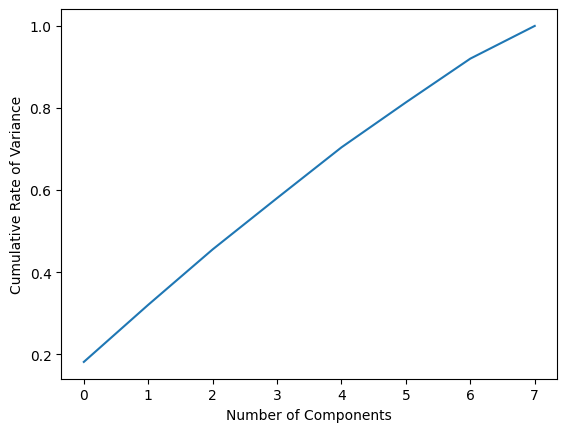

In [ ]:
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Rate of Variance")
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.show()

In [ ]:
var1 = np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 4) * 100)
print(var1)

[ 18.12  32.04  45.54  58.04  70.41  81.37  92.03 100.  ]


Text(0, 0.5, 'Cumulative Proportion variance explained')

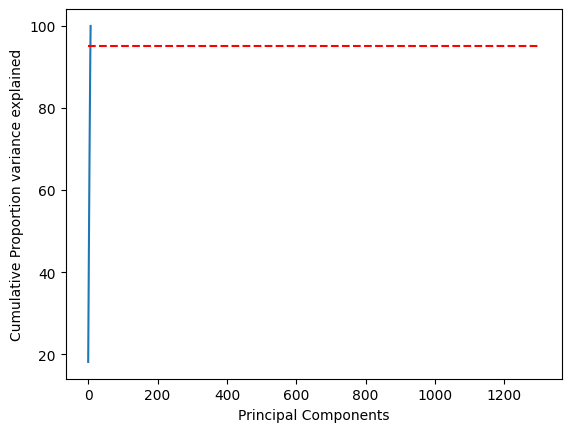

In [ ]:
plt.plot(var1)
plt.hlines(95,0,1300,colors='red',linestyles='dashed')
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Proportion variance explained")

In [ ]:
# to find principal component which is taken greather than 95 %
Num_components = var1<95
print("Optimum Number of Components", Num_components.sum())

Optimum Number of Components 7


In [ ]:
pesquisaPCA = pesquisa.copy()
pesquisaPCA = pesquisaPCA.reset_index(drop=True)

In [ ]:
y = pesquisaPCA['Faixa IMC'] # Dependent variable
X = pesquisaPCA.drop(['Ano', 'Faixa IMC', "IMC"], axis=1) # Independent Variable

def create_pca_df(X, y):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(X)
    pca_df = pd.DataFrame(data=pca_fit, columns=['PC1', 'PC2'])
    final_df = pd.concat([pca_df, pd.DataFrame(y)], axis=1, ignore_index=True)
    return final_df

pca_df = create_pca_df(X, y)
#rename columns
pca_df.columns = ['PC1', 'PC2', 'Faixa IMC']
pca_df.head()

,PC1,PC2,Faixa IMC
0,-1.537978,0.105378,Peso normal
1,-1.539245,1.261783,Sobrepeso
2,-0.422891,0.309349,Sobrepeso
3,0.876266,0.358303,Sobrepeso
4,0.203166,0.593193,Obesidade grau 1


In [ ]:
X.tail()

,Cidade,Faixa Etária,Genero,Faixa de Escolaridade,Exercicio Fisico,Estado de Saúde,Cor
694083,9,4,2,1,2,2,1.0
694084,9,6,2,2,1,1,3.0
694085,9,5,2,3,2,2,1.0
694086,9,2,2,3,2,2,1.0
694087,9,5,2,3,2,3,1.0


6


<ipython-input-185-5bb4a32be8c8>:16: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



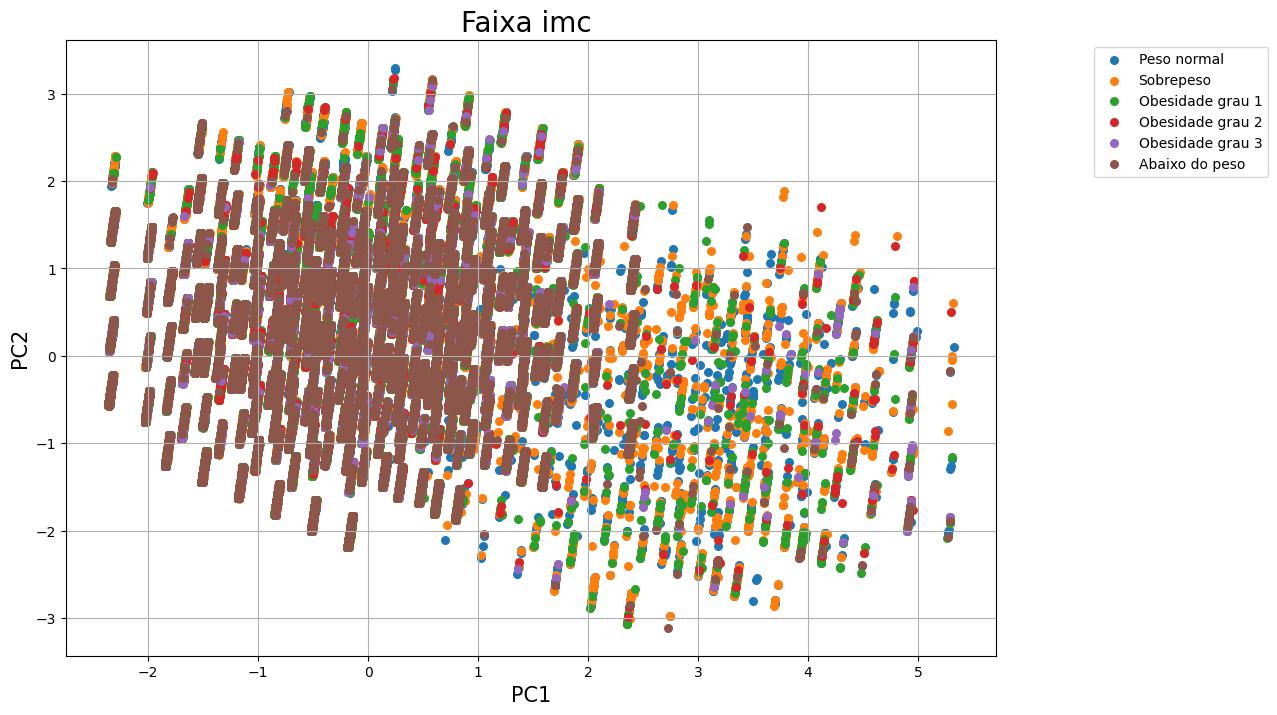

In [ ]:
def plot_pca(dataframe, target):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PC1', fontsize=15)
    ax.set_ylabel('PC2', fontsize=15)
    ax.set_title(f'{target.capitalize()} ', fontsize=20)

    targets = list(dataframe[target].unique())
    a = len(targets)
    print(a)

    colors = random.sample(["black", "red","yellow","green","black", "red"], len(targets))

    for t, color in zip(targets, colors):
        indices = dataframe[target] == t
        ax.scatter(dataframe.loc[indices, 'PC1'], dataframe.loc[indices, 'PC2'], cmap='viridis', s=30)
    ax.legend(targets, loc='upper right', bbox_to_anchor=(1.3, 1))
    ax.grid()
    plt.show()

plot_pca(pca_df, "Faixa IMC")

In [ ]:
# Calcular e imprimir a matriz de covariância
cov_matrix = np.cov(X.T)
print("Matriz de Covariância:")
print(cov_matrix)

#Dois maiores autovalores:

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print("\nAutovalores:")
print(eigenvalues)
print("\nAutovetores:")
print(eigenvectors)

# Ordenar os autovalores e autovetores em ordem decrescente
eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(len(eigenvalues))]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

# Selecionar os dois maiores autovalores e autovetores
top_eigenvalues = eigen_pairs[0][0], eigen_pairs[1][0]
top_eigenvectors = eigen_pairs[0][1], eigen_pairs[1][1]

print("\nDois maiores autovalores:")
print(top_eigenvalues)
print("\nDois maiores autovetores:")
print(top_eigenvectors)

Matriz de Covariância:
[[ 6.09469866e+01  5.06822404e-02  1.01404901e-02  1.17367046e-01
   3.05346569e-02  9.20396486e-01 -2.47875211e-02]
 [ 5.06822404e-02  2.68904667e+00  6.23524935e-02 -3.13976496e-01
   5.59810502e-02  4.63914445e+00 -2.04192923e-01]
 [ 1.01404901e-02  6.23524935e-02  2.40276987e-01  6.62308958e-04
   2.87440424e-02  5.98135036e-02 -1.69333919e-02]
 [ 1.17367046e-01 -3.13976496e-01  6.62308958e-04  6.02319739e-01
  -7.48594266e-02 -1.86388201e+00 -8.53671435e-02]
 [ 3.05346569e-02  5.59810502e-02  2.87440424e-02 -7.48594266e-02
   2.48664658e-01  6.69969262e-01  1.55765346e-02]
 [ 9.20396486e-01  4.63914445e+00  5.98135036e-02 -1.86388201e+00
   6.69969262e-01  2.89350660e+03 -4.20570534e-01]
 [-2.47875211e-02 -2.04192923e-01 -1.69333919e-02 -8.53671435e-02
   1.55765346e-02 -4.20570534e-01  1.71062089e+00]]

Autovalores:
[2.89351577e+03 6.09469859e+01 2.76435256e+00 1.68850314e+00
 5.56962597e-01 2.07384963e-01 2.64563231e-01]

Autovetores:
[[-3.24938841e-04 -9.

In [ ]:
pesquisa.shape

(695760, 12)

In [ ]:
pesquisa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695760 entries, 0 to 54366
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Ano                    695760 non-null  int64  
 1   Cidade                 695760 non-null  object 
 2   IMC                    695760 non-null  float64
 3   Faixa Etária           695760 non-null  object 
 4   Genero                 695760 non-null  object 
 5   Faixa de Escolaridade  695760 non-null  object 
 6   Exercicio Fisico       695760 non-null  object 
 7   Estado de Saúde        695760 non-null  object 
 8   Cor                    695760 non-null  object 
 9   Faixa IMC              695181 non-null  object 
 10  Regiao                 668866 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 63.7+ MB


# **Média + Desvio Padrão de IMC por ANO**

---



---



In [ ]:
AnoImcMedia = pd.DataFrame(pesquisa.groupby("Ano")["IMC"].mean().round(2))
AnoImcDesvio = pd.DataFrame(pesquisa.groupby("Ano")["IMC"].std().round(2))
AnoImcMediana = pd.DataFrame(pesquisa.groupby("Ano")["IMC"].median().round(2))

AnoImcTable = pd.DataFrame()
AnoImcTable = AnoImcMedia

AnoImcTable["Media"] = AnoImcMedia.IMC.values.T
AnoImcTable["Desvio"] = AnoImcDesvio.IMC.values.T
AnoImcTable["Median"] = AnoImcMediana.IMC.values.T


# AnoImcModa2006 = AnoImcModa2006["IMC"].mode().round(2)
# AnoImcModa2006
AnoImcData = pd.DataFrame()
AnoImcData["Media"] = AnoImcTable["Media"]
AnoImcData[""] = "±"
AnoImcData["Desvio Padrao"] = AnoImcTable["Desvio"]
AnoImcData.to_excel('IMC_Media_Desvio.xlsx')

(695760, 12)

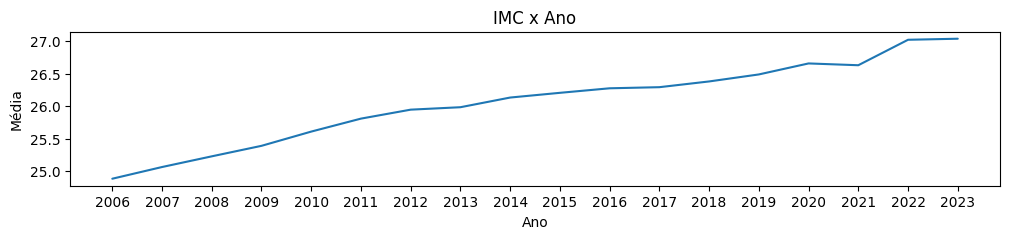

In [ ]:
dataAno  = pesquisa.groupby("Ano")["IMC"].mean().reset_index()
dataAno = pd.DataFrame(dataAno)
#Criação do gráfico de linha para o total de óbitos
plt.figure(figsize=(12, 2))
plt.title("IMC x Ano")
sns.set_theme(style="whitegrid")

a = sns.lineplot(data=dataAno, x="Ano", y="IMC")
a.set(xlabel='Ano', ylabel='Média')
#show all years in x axis
plt.xticks(dataAno["Ano"])
#add numbers in line
# for x, y in zip(obitoPeriodo["Ano"], obitoPeriodo["Total de Óbitos"]):
#     plt.text(x, y, y, color='black', ha='center')
plt.show()

In [ ]:
anoImc = pesquisa.groupby("Ano")["IMC"].mean()
anoImc = pd.DataFrame(anoImc)
anoIMC2006 = anoImc.query("Ano == 2006")
anoIMC2023 = anoImc.query("Ano == 2023")

diferencaIMC =  (anoIMC2023.values - anoIMC2006.values)/anoIMC2006.values

In [ ]:
(diferencaIMC[0][0]*100).round(2)

8.64

In [ ]:
anoImc.min().round(2)

IMC    24.88
dtype: float64

In [ ]:
anoImc.max().round(2)

IMC    27.03
dtype: float64

,Ano,IMC
0,2006,24.884484
1,2007,25.064124
2,2008,25.228296
3,2009,25.389648
4,2010,25.608432
5,2011,25.807671
6,2012,25.945256
7,2013,25.982707
8,2014,26.131233
9,2015,26.203756


In [ ]:
# prompt: Usando o DataFrame dataAno: transpose DataAno

dataAno.transpose()


In [ ]:
import numpy as np
from matplotlib.colors import to_rgba, TwoSlopeNorm

NameError: name 'xlim' is not defined

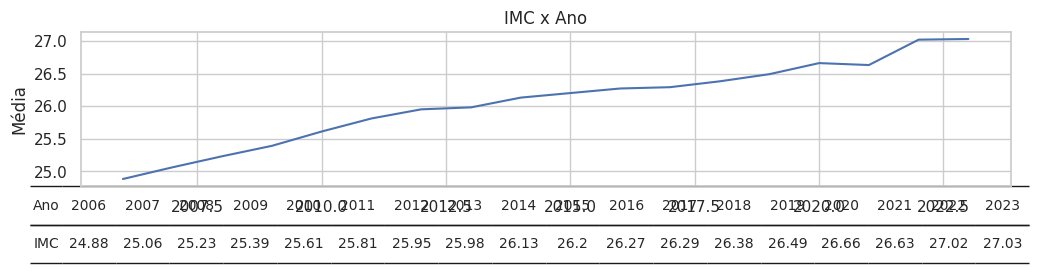

In [ ]:
dataAno  = pesquisa.groupby("Ano")["IMC"].mean().reset_index()
dataAno = pd.DataFrame(dataAno)
dataAno["IMC"] = dataAno["IMC"].round(2)

#Criação do gráfico de linha para o total de óbitos
plt.figure(figsize=(12, 2))
plt.title("IMC x Ano")
sns.set_theme(style="whitegrid")



#show all years in x axis
dataAnoT = dataAno.transpose()
dataAnoT.iloc[0] = dataAnoT.iloc[0].astype(int)
dataAnoT.iloc[0] = dataAnoT.iloc[0].apply(lambda x: str(x)[:-2])
# white = [['white' if not np.issubdtype(type(val), np.number) else 'white' for val in row]
#            for row in dataAnoT.values]
a = sns.lineplot(data=dataAno, x="Ano", y="IMC")
a.set(xlabel=None, ylabel='Média')
table = plt.table(cellText=dataAnoT.values,
                  rowLabels=dataAnoT.index,
                  loc='bottom',
                  bbox=(-0.02, -0.5, 1.04, 0.5),
                  cellLoc='center',
                  edges= 'horizontal',
                  zorder=2)

plt.xlim(xlim[0]+0.7,xlim[1]-0.7)
table.auto_set_font_size(False)
table.set_fontsize(11)
a.set(xticklabels=[])
a.tick_params(bottom=False)
plt.xticks(dataAno["Ano"])

plt.show()

In [ ]:
dataAnoT

False

In [ ]:
# prompt: Usando o DataFrame dataAnoT: Convert first row to int and remove .0




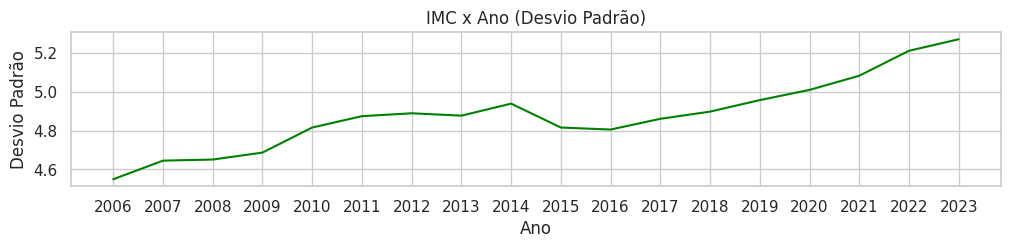

In [ ]:
dataAno  = pesquisa.groupby("Ano")["IMC"].std().reset_index()
dataAno = pd.DataFrame(dataAno)
#Criação do gráfico de linha para o total de óbitos
plt.figure(figsize=(12, 2))
plt.title("IMC x Ano (Desvio Padrão)")
sns.set_theme(style="whitegrid")

a = sns.lineplot(data=dataAno, x="Ano", y="IMC", color="green")
a.set(xlabel='Ano', ylabel='Desvio Padrão')
#show all years in x axis
plt.xticks(dataAno["Ano"])
#add numbers in line
# for x, y in zip(obitoPeriodo["Ano"], obitoPeriodo["Total de Óbitos"]):
#     plt.text(x, y, y, color='black', ha='center')
plt.show()

# **Média e Desvio Padrão por Estado de Saúde Anual**

---



---



In [ ]:
AnoEstadoSaudeImcMedia = pd.DataFrame(pesquisa.groupby(["Estado de Saúde", "Ano"])["IMC"].mean().round(2))
AnoEstadoSaudeImcDesvio = pd.DataFrame(pesquisa.groupby(["Estado de Saúde", "Ano"])["IMC"].std().round(2))
AnoEstadoSaudeImcMediana = pd.DataFrame(pesquisa.groupby(["Estado de Saúde", "Ano"])["IMC"].median().round(2))
AnoEstadoSaudeImcMediana = pd.DataFrame(pesquisa.groupby(["Estado de Saúde", "Ano"])["IMC"].mode().round(2))
AnoEstadoSaudeImcMedia
# AnoEstadoSaudeImcData = pd.DataFrame()
# AnoEstadoSaudeImcData["Media - Desvio Padrão"] = AnoEstadoSaudeImcMedia
# AnoEstadoSaudeImcData[""] = "±"
# AnoEstadoSaudeImcData["Desvio Padrao"] = AnoEstadoSaudeImcDesvio
# AnoEstadoSaudeImcData.to_excel('EstadoSaude_IMC_Media_Desvio.xlsx')


IMC
Estado de Saúde Ano        
                2007  25.78
                2008  27.18
                2009  25.37
                2010  26.42
                2011  26.51
...                     ...
Ruim            2019  28.60
                2020  28.57
                2021  28.85
                2022  29.32
                2023  29.82

[105 rows x 1 columns]

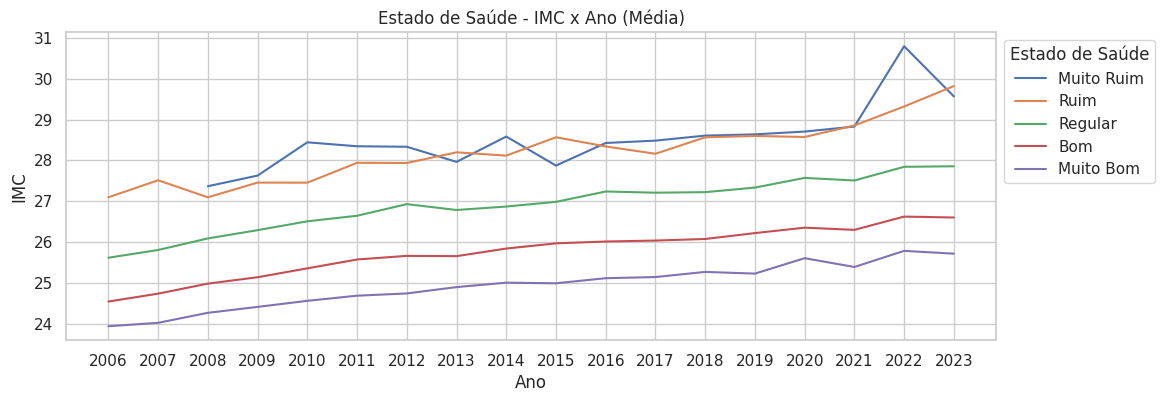

In [ ]:
dataMuitoRuim  = pesquisa[pesquisa["Estado de Saúde"] == "Muito ruim"]
dataRuim   = pesquisa[pesquisa["Estado de Saúde"] == "Ruim"]
dataRegular    = pesquisa[pesquisa["Estado de Saúde"] == "Regular"]
dataBom    = pesquisa[pesquisa["Estado de Saúde"] == "Bom"]
dataMuitoBom = pesquisa[pesquisa["Estado de Saúde"] == "Muito bom"]

dataMuitoRuim  = dataMuitoRuim.groupby(["Estado de Saúde", "Ano"])["IMC"].mean().reset_index()
dataRuim   = dataRuim.groupby(["Estado de Saúde", "Ano"])["IMC"].mean().reset_index()
dataRegular    = dataRegular.groupby(["Estado de Saúde", "Ano"])["IMC"].mean().reset_index()
dataBom    = dataBom.groupby(["Estado de Saúde", "Ano"])["IMC"].mean().reset_index()
dataMuitoBom = dataMuitoBom.groupby(["Estado de Saúde", "Ano"])["IMC"].mean().reset_index()

dataMuitoRuim = pd.DataFrame(dataMuitoRuim)
dataRuim = pd.DataFrame(dataRuim)
dataRegular = pd.DataFrame(dataRegular)
dataBom = pd.DataFrame(dataBom)
dataMuitoBom = pd.DataFrame(dataMuitoBom)

#Criação do gráfico de linha para o Estado de Saúde de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Estado de Saúde - IMC x Ano (Média)")
sns.set_theme(style="whitegrid")
sns.lineplot(data=dataMuitoRuim, x="Ano", y="IMC", label="Muito Ruim")
sns.lineplot(data=dataRuim, x="Ano", y="IMC", label="Ruim")
sns.lineplot(data=dataRegular, x="Ano", y="IMC", label="Regular")
sns.lineplot(data=dataBom, x="Ano", y="IMC", label="Bom")
a = sns.lineplot(data=dataMuitoBom, x="Ano", y="IMC", label="Muito Bom")
plt.legend(title='Estado de Saúde')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

#show all years in x axis
plt.xticks(dataMuitoBom['Ano'])
plt.show()

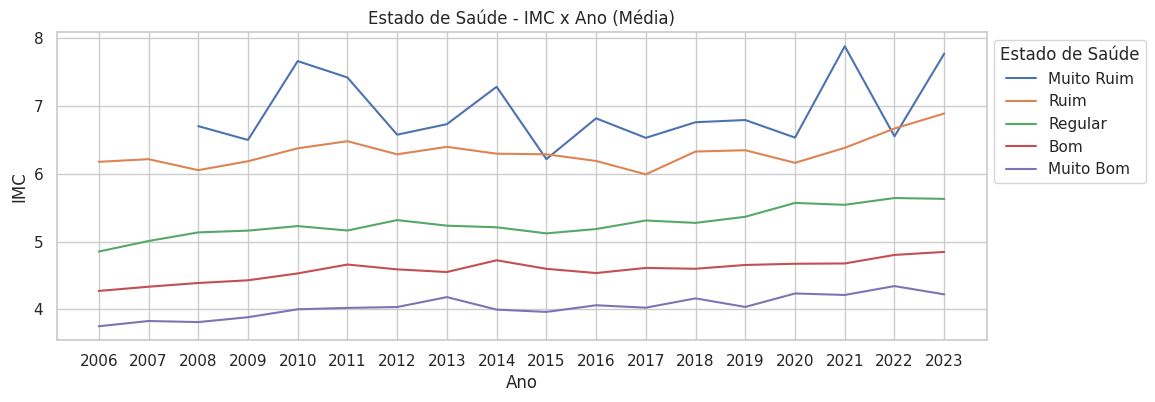

In [ ]:
dataMuitoRuimStd  = pesquisa[pesquisa["Estado de Saúde"] == "Muito ruim"]
dataRuimStd   = pesquisa[pesquisa["Estado de Saúde"] == "Ruim"]
dataRegularStd    = pesquisa[pesquisa["Estado de Saúde"] == "Regular"]
dataBomStd    = pesquisa[pesquisa["Estado de Saúde"] == "Bom"]
dataMuitoBomStd = pesquisa[pesquisa["Estado de Saúde"] == "Muito bom"]

dataMuitoRuimStd  = dataMuitoRuimStd.groupby(["Estado de Saúde", "Ano"])["IMC"].std().reset_index()
dataRuimStd   = dataRuimStd.groupby(["Estado de Saúde", "Ano"])["IMC"].std().reset_index()
dataRegularStd    = dataRegularStd.groupby(["Estado de Saúde", "Ano"])["IMC"].std().reset_index()
dataBomStd    = dataBomStd.groupby(["Estado de Saúde", "Ano"])["IMC"].std().reset_index()
dataMuitoBomStd = dataMuitoBomStd.groupby(["Estado de Saúde", "Ano"])["IMC"].std().reset_index()

dataMuitoRuimStd = pd.DataFrame(dataMuitoRuimStd)
dataRuimStd = pd.DataFrame(dataRuimStd)
dataRegularStd = pd.DataFrame(dataRegularStd)
dataBomStd = pd.DataFrame(dataBomStd)
dataMuitoBomStd = pd.DataFrame(dataMuitoBomStd)

#Criação do gráfico de linha para o Estado de Saúde de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Estado de Saúde - IMC x Ano (Média)")
sns.set_theme(style="whitegrid")
sns.lineplot(data=dataMuitoRuimStd, x="Ano", y="IMC", label="Muito Ruim")
sns.lineplot(data=dataRuimStd, x="Ano", y="IMC", label="Ruim")
sns.lineplot(data=dataRegularStd, x="Ano", y="IMC", label="Regular")
sns.lineplot(data=dataBomStd, x="Ano", y="IMC", label="Bom")
a = sns.lineplot(data=dataMuitoBomStd, x="Ano", y="IMC", label="Muito Bom")
plt.legend(title='Estado de Saúde')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

#show all years in x axis
plt.xticks(dataMuitoBomStd['Ano'])
plt.show()

# **Média e Desvio Padrão por Regiao Anual**

---



---



In [ ]:
AnoRegiaoImcMedia = pd.DataFrame(pesquisa.groupby(["Regiao", "Ano"])["IMC"].mean().round(2))
AnoRegiaoImcDesvio = pd.DataFrame(pesquisa.groupby(["Regiao", "Ano"])["IMC"].std().round(2))

AnoRegiaoImcData = pd.DataFrame()
AnoRegiaoImcData["Media ± Desvio Padrão"] = AnoRegiaoImcMedia
AnoRegiaoImcData[""] = "±"
AnoRegiaoImcData["Desvio Padrao"] = AnoRegiaoImcDesvio
AnoRegiaoImcData.to_excel('Regiao_IMC_Media_Desvio.xlsx')

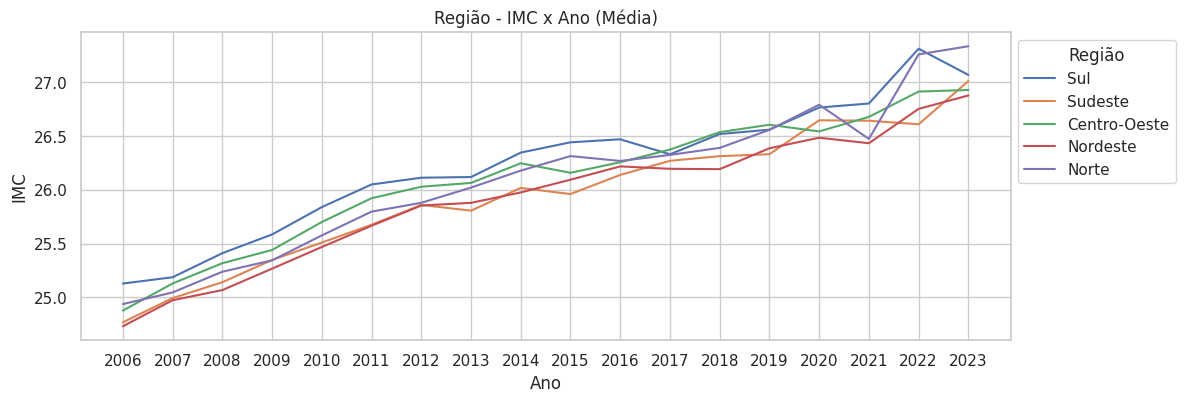

In [ ]:
dataSul  = pesquisa[pesquisa["Regiao"] == "Sul"]
dataSudeste   = pesquisa[pesquisa["Regiao"] == "Sudeste"]
dataCentroOeste   = pesquisa[pesquisa["Regiao"] == "Centro-Oeste"]
dataNordeste    = pesquisa[pesquisa["Regiao"] == "Nordeste"]
dataNorte = pesquisa[pesquisa["Regiao"] == "Norte"]

dataSul  = dataSul.groupby(["Regiao", "Ano"])["IMC"].mean().reset_index()
dataSudeste   = dataSudeste.groupby(["Regiao", "Ano"])["IMC"].mean().reset_index()
dataCentroOeste    = dataCentroOeste.groupby(["Regiao", "Ano"])["IMC"].mean().reset_index()
dataNordeste    = dataNordeste.groupby(["Regiao", "Ano"])["IMC"].mean().reset_index()
dataNorte = dataNorte.groupby(["Regiao", "Ano"])["IMC"].mean().reset_index()

dataSul = pd.DataFrame(dataSul)
dataSudeste = pd.DataFrame(dataSudeste)
dataCentroOeste = pd.DataFrame(dataCentroOeste)
dataNordeste = pd.DataFrame(dataNordeste)
dataNorte = pd.DataFrame(dataNorte)

#Criação do gráfico de linha para o Estado de Saúde de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Região - IMC x Ano (Média)")
sns.set_theme(style="whitegrid")
sns.lineplot(data=dataSul, x="Ano", y="IMC", label="Sul")
sns.lineplot(data=dataSudeste, x="Ano", y="IMC", label="Sudeste")
sns.lineplot(data=dataCentroOeste, x="Ano", y="IMC", label="Centro-Oeste")
sns.lineplot(data=dataNordeste, x="Ano", y="IMC", label="Nordeste")
a = sns.lineplot(data=dataNorte, x="Ano", y="IMC", label="Norte")

plt.legend(title='Região')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(dataNorte['Ano'])
plt.show()

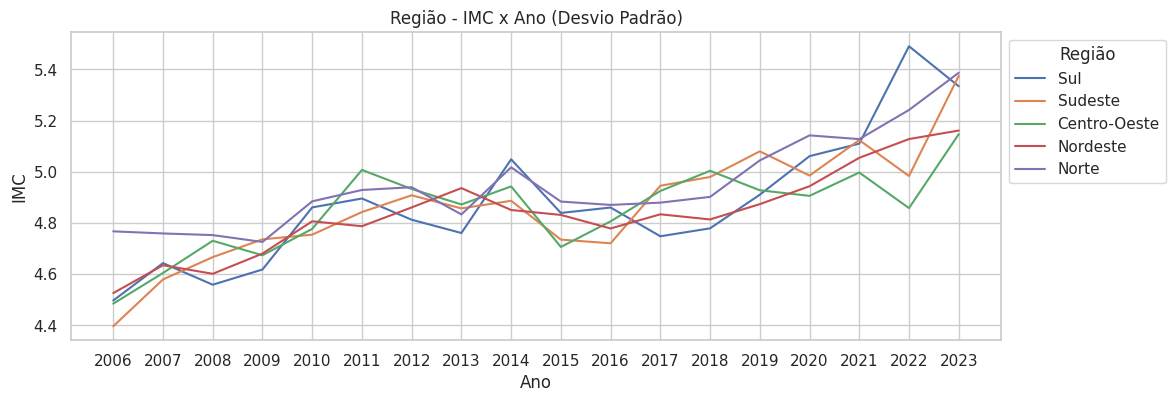

In [ ]:
dataSulStd  = pesquisa[pesquisa["Regiao"] == "Sul"]
dataSudesteStd   = pesquisa[pesquisa["Regiao"] == "Sudeste"]
dataCentroOesteStd   = pesquisa[pesquisa["Regiao"] == "Centro-Oeste"]
dataNordesteStd    = pesquisa[pesquisa["Regiao"] == "Nordeste"]
dataNorteStd = pesquisa[pesquisa["Regiao"] == "Norte"]

dataSulStd  = dataSulStd.groupby(["Regiao", "Ano"])["IMC"].std().reset_index()
dataSudesteStd   = dataSudesteStd.groupby(["Regiao", "Ano"])["IMC"].std().reset_index()
dataCentroOesteStd    = dataCentroOesteStd.groupby(["Regiao", "Ano"])["IMC"].std().reset_index()
dataNordesteStd    = dataNordesteStd.groupby(["Regiao", "Ano"])["IMC"].std().reset_index()
dataNorteStd = dataNorteStd.groupby(["Regiao", "Ano"])["IMC"].std().reset_index()

dataSulStd = pd.DataFrame(dataSulStd)
dataSudesteStd = pd.DataFrame(dataSudesteStd)
dataCentroOesteStd = pd.DataFrame(dataCentroOesteStd)
dataNordesteStd = pd.DataFrame(dataNordesteStd)
dataNorteStd = pd.DataFrame(dataNorteStd)

#Criação do gráfico de linha para o Estado de Saúde de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Região - IMC x Ano (Desvio Padrão)")
sns.set_theme(style="whitegrid")
sns.lineplot(data=dataSulStd, x="Ano", y="IMC", label="Sul")
sns.lineplot(data=dataSudesteStd, x="Ano", y="IMC", label="Sudeste")
sns.lineplot(data=dataCentroOesteStd, x="Ano", y="IMC", label="Centro-Oeste")
sns.lineplot(data=dataNordesteStd, x="Ano", y="IMC", label="Nordeste")
a = sns.lineplot(data=dataNorteStd, x="Ano", y="IMC", label="Norte")

plt.legend(title='Região')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(dataNorteStd['Ano'])
plt.show()

# **Média e Desvio Padrão por Faixa Etaria Anual**

---



---



In [ ]:
AnoFaixaEtariaImcMedia = pd.DataFrame(pesquisa.groupby(["Faixa Etária", "Ano"])["IMC"].mean().round(2))
AnoFaixaEtariaImcDesvio = pd.DataFrame(pesquisa.groupby(["Faixa Etária", "Ano"])["IMC"].std().round(2))

AnoFaixaEtariaImcData = pd.DataFrame()
AnoFaixaEtariaImcData["Media ± Desvio Padrão"] = AnoFaixaEtariaImcMedia
AnoFaixaEtariaImcData[""] = "±"
AnoFaixaEtariaImcData["Desvio Padrao"] = AnoFaixaEtariaImcDesvio
AnoFaixaEtariaImcData.to_excel('FaixaEtaria_IMC_Media_Desvio.xlsx')

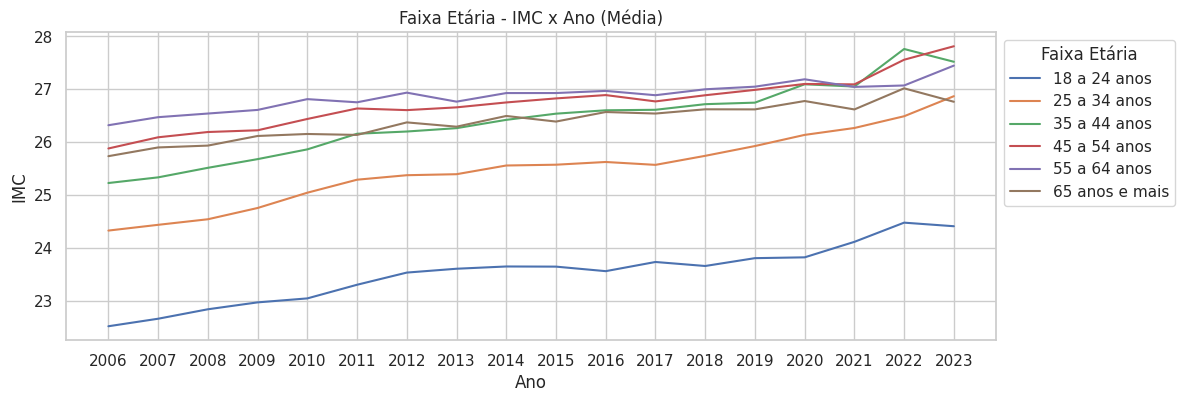

In [ ]:
data18_24  = pesquisa[pesquisa["Faixa Etária"] == "18 a 24 anos"]
data25_34   = pesquisa[pesquisa["Faixa Etária"] == "25 a 34 anos"]
data35_44   = pesquisa[pesquisa["Faixa Etária"] == "35 a 44 anos"]
data45_54    = pesquisa[pesquisa["Faixa Etária"] == "45 a 54 anos"]
data55_64 = pesquisa[pesquisa["Faixa Etária"] == "55 a 64 anos"]
data65Mais = pesquisa[pesquisa["Faixa Etária"] == "65 anos e mais"]

data18_24  = data18_24.groupby(["Faixa Etária", "Ano"])["IMC"].mean().reset_index()
data25_34   = data25_34.groupby(["Faixa Etária", "Ano"])["IMC"].mean().reset_index()
data35_44    = data35_44.groupby(["Faixa Etária", "Ano"])["IMC"].mean().reset_index()
data45_54    = data45_54.groupby(["Faixa Etária", "Ano"])["IMC"].mean().reset_index()
data55_64 = data55_64.groupby(["Faixa Etária", "Ano"])["IMC"].mean().reset_index()
data65Mais = data65Mais.groupby(["Faixa Etária", "Ano"])["IMC"].mean().reset_index()

data18_24 = pd.DataFrame(data18_24)
data25_34 = pd.DataFrame(data25_34)
data35_44 = pd.DataFrame(data35_44)
data45_54 = pd.DataFrame(data45_54)
data55_64 = pd.DataFrame(data55_64)
data65Mais = pd.DataFrame(data65Mais)

#Criação do gráfico de linha para o Faixa Etária de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Faixa Etária - IMC x Ano (Média)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=data18_24, x="Ano", y="IMC", label="18 a 24 anos")
sns.lineplot(data=data25_34, x="Ano", y="IMC", label="25 a 34 anos")
sns.lineplot(data=data35_44, x="Ano", y="IMC", label="35 a 44 anos")
sns.lineplot(data=data45_54, x="Ano", y="IMC", label="45 a 54 anos")
sns.lineplot(data=data55_64, x="Ano", y="IMC", label="55 a 64 anos")
a = sns.lineplot(data=data65Mais, x="Ano", y="IMC", label="65 anos e mais")

plt.legend(title='Faixa Etária')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

#show all years in x axis
plt.xticks(data65Mais['Ano'])
plt.show()

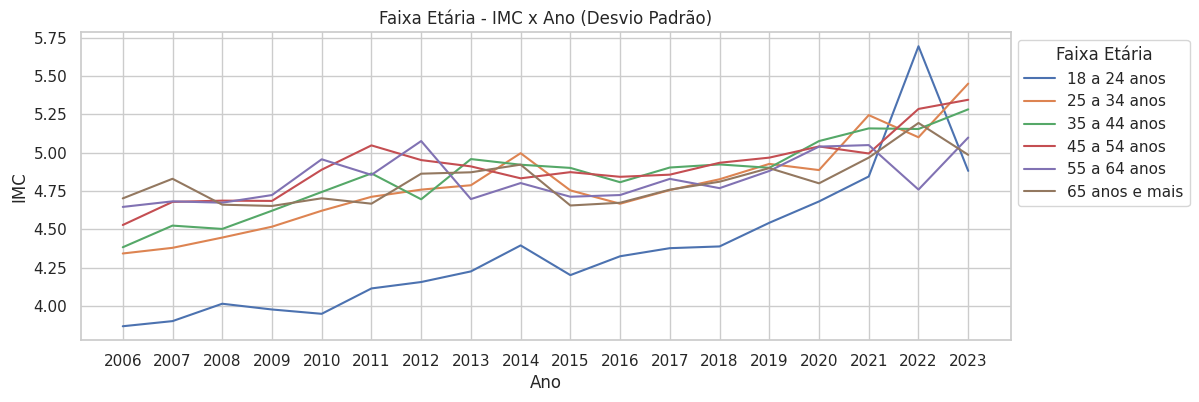

In [ ]:
data18_24Std  = pesquisa[pesquisa["Faixa Etária"] == "18 a 24 anos"]
data25_34Std   = pesquisa[pesquisa["Faixa Etária"] == "25 a 34 anos"]
data35_44Std   = pesquisa[pesquisa["Faixa Etária"] == "35 a 44 anos"]
data45_54Std    = pesquisa[pesquisa["Faixa Etária"] == "45 a 54 anos"]
data55_64Std = pesquisa[pesquisa["Faixa Etária"] == "55 a 64 anos"]
data65MaisStd = pesquisa[pesquisa["Faixa Etária"] == "65 anos e mais"]

data18_24Std  = data18_24Std.groupby(["Faixa Etária", "Ano"])["IMC"].std().reset_index()
data25_34Std   = data25_34Std.groupby(["Faixa Etária", "Ano"])["IMC"].std().reset_index()
data35_44Std    = data35_44Std.groupby(["Faixa Etária", "Ano"])["IMC"].std().reset_index()
data45_54Std    = data45_54Std.groupby(["Faixa Etária", "Ano"])["IMC"].std().reset_index()
data55_64Std = data55_64Std.groupby(["Faixa Etária", "Ano"])["IMC"].std().reset_index()
data65MaisStd = data65MaisStd.groupby(["Faixa Etária", "Ano"])["IMC"].std().reset_index()

data18_24Std = pd.DataFrame(data18_24Std)
data25_34Std = pd.DataFrame(data25_34Std)
data35_44Std = pd.DataFrame(data35_44Std)
data45_54Std = pd.DataFrame(data45_54Std)
data55_64Std = pd.DataFrame(data55_64Std)
data65MaisStd = pd.DataFrame(data65MaisStd)

#Criação do gráfico de linha para o Faixa Etária de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Faixa Etária - IMC x Ano (Desvio Padrão)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=data18_24Std, x="Ano", y="IMC", label="18 a 24 anos")
sns.lineplot(data=data25_34Std, x="Ano", y="IMC", label="25 a 34 anos")
sns.lineplot(data=data35_44Std, x="Ano", y="IMC", label="35 a 44 anos")
sns.lineplot(data=data45_54Std, x="Ano", y="IMC", label="45 a 54 anos")
sns.lineplot(data=data55_64Std, x="Ano", y="IMC", label="55 a 64 anos")
a = sns.lineplot(data=data65MaisStd, x="Ano", y="IMC", label="65 anos e mais")

plt.legend(title='Faixa Etária')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

#show all years in x axis
plt.xticks(data65MaisStd['Ano'])
plt.show()

# **Média e Desvio Padrão por Gênero Anual**

---



---



In [ ]:
AnoGeneroImcMedia = pd.DataFrame(pesquisa.groupby(["Genero", "Ano"])["IMC"].mean().round(2))
AnoGeneroImcDesvio = pd.DataFrame(pesquisa.groupby(["Genero", "Ano"])["IMC"].std().round(2))

AnoGeneroImcData = pd.DataFrame()
AnoGeneroImcData["Media ± Desvio Padrão"] = AnoGeneroImcMedia
AnoGeneroImcData[""] = "±"
AnoGeneroImcData["Desvio Padrao"] = AnoGeneroImcDesvio
AnoGeneroImcData.to_excel('Genero_IMC_Media_Desvio.xlsx')

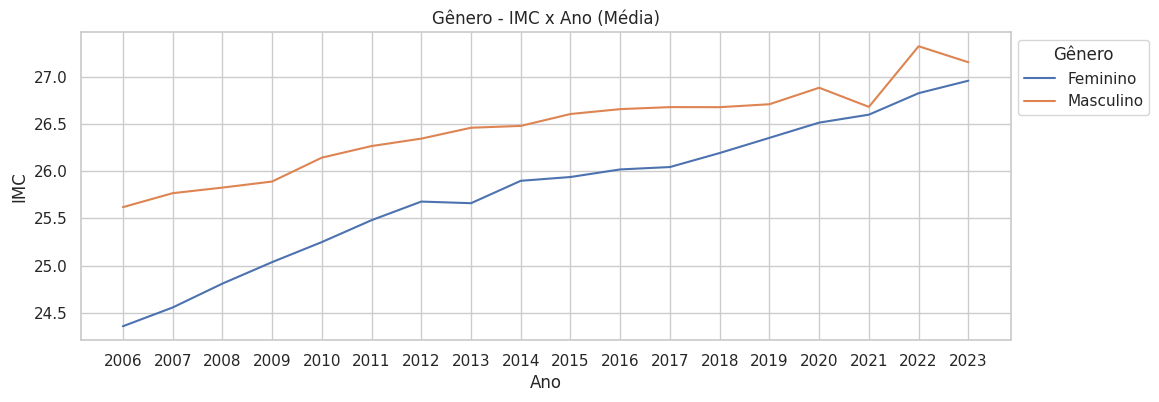

In [ ]:
dataFeminino  = pesquisa[pesquisa["Genero"] == "Feminino"]
dataMasculino   = pesquisa[pesquisa["Genero"] == "Masculino"]

dataFeminino  = dataFeminino.groupby(["Genero", "Ano"])["IMC"].mean().reset_index()
dataMasculino   = dataMasculino.groupby(["Genero", "Ano"])["IMC"].mean().reset_index()

dataFeminino = pd.DataFrame(dataFeminino)
dataMasculino = pd.DataFrame(dataMasculino)

#Criação do gráfico de linha para o Genero de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Gênero - IMC x Ano (Média)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=dataFeminino, x="Ano", y="IMC", label="Feminino")
a = sns.lineplot(data=dataMasculino, x="Ano", y="IMC", label="Masculino")

plt.legend(title='Gênero')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(dataMasculino['Ano'])
plt.show()

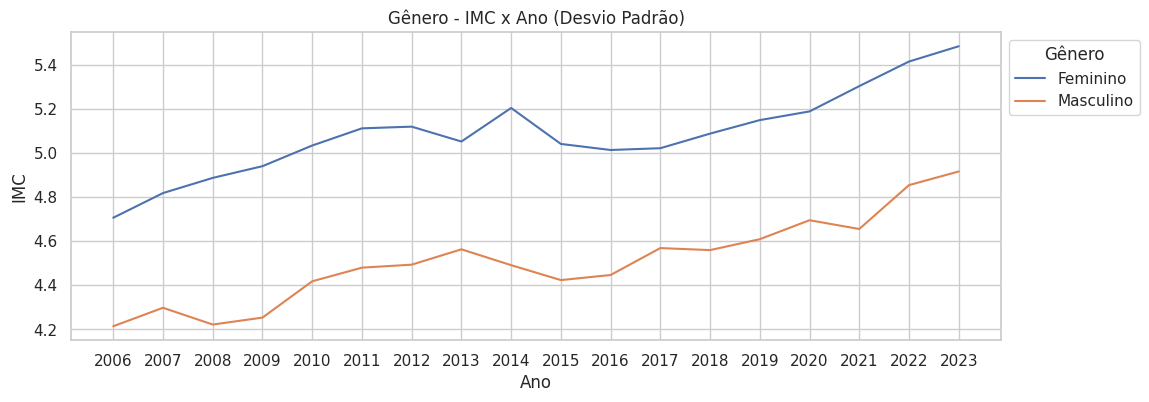

In [ ]:
dataFemininoStd  = pesquisa[pesquisa["Genero"] == "Feminino"]
dataMasculinoStd   = pesquisa[pesquisa["Genero"] == "Masculino"]

dataFemininoStd  = dataFemininoStd.groupby(["Genero", "Ano"])["IMC"].std().reset_index()
dataMasculinoStd   = dataMasculinoStd.groupby(["Genero", "Ano"])["IMC"].std().reset_index()

dataFemininoStd = pd.DataFrame(dataFemininoStd)
dataMasculinoStd = pd.DataFrame(dataMasculinoStd)

#Criação do gráfico de linha para o Genero de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Gênero - IMC x Ano (Desvio Padrão)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=dataFemininoStd, x="Ano", y="IMC", label="Feminino")
a = sns.lineplot(data=dataMasculinoStd, x="Ano", y="IMC", label="Masculino")

plt.legend(title='Gênero')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(dataMasculinoStd['Ano'])
plt.show()

# **Média e Desvio Padrão por Faixa de Escolaridade Anual**

---



---



In [ ]:
AnoFaixaEscolaridadeImcMedia = pd.DataFrame(pesquisa.groupby(["Faixa de Escolaridade", "Ano"])["IMC"].mean().round(2))
AnoFaixaEscolaridadeImcDesvio = pd.DataFrame(pesquisa.groupby(["Faixa de Escolaridade", "Ano"])["IMC"].std().round(2))

AnoFaixaEscolaridadeImcData = pd.DataFrame()
AnoFaixaEscolaridadeImcData["Media ± Desvio Padrão"] = AnoFaixaEscolaridadeImcMedia
AnoFaixaEscolaridadeImcData[""] = "±"
AnoFaixaEscolaridadeImcData["Desvio Padrao"] = AnoFaixaEscolaridadeImcDesvio
AnoFaixaEscolaridadeImcData.to_excel('FaixaEscolaridade_IMC_Media_Desvio.xlsx')

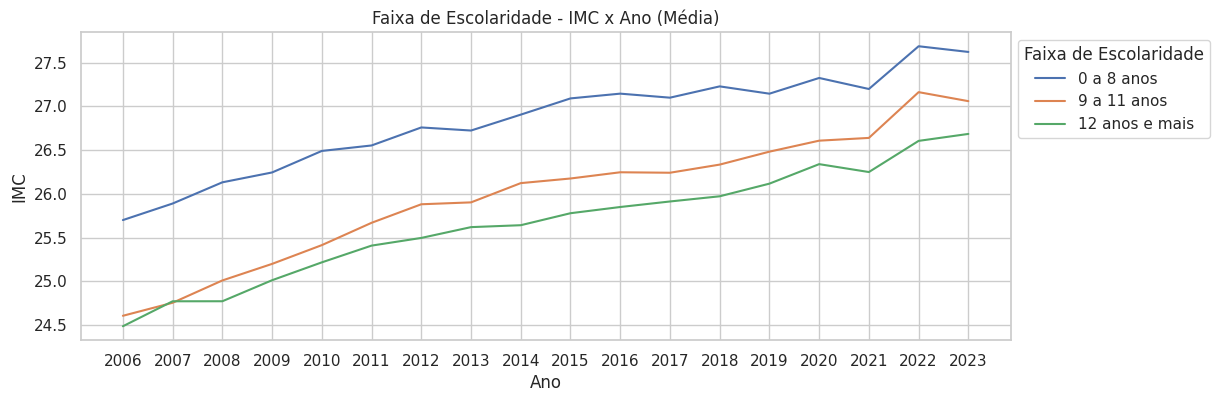

In [ ]:
data0_8  = pesquisa[pesquisa["Faixa de Escolaridade"] == "0 a 8 anos"]
data9_11   = pesquisa[pesquisa["Faixa de Escolaridade"] == "9 a 11 anos"]
data12Mais   = pesquisa[pesquisa["Faixa de Escolaridade"] == "12 anos e mais"]

data0_8  = data0_8.groupby(["Faixa de Escolaridade", "Ano"])["IMC"].mean().reset_index()
data9_11   = data9_11.groupby(["Faixa de Escolaridade", "Ano"])["IMC"].mean().reset_index()
data12Mais   = data12Mais.groupby(["Faixa de Escolaridade", "Ano"])["IMC"].mean().reset_index()

data0_8 = pd.DataFrame(data0_8)
data9_11 = pd.DataFrame(data9_11)
data12Mais = pd.DataFrame(data12Mais)

#Criação do gráfico de linha para o Genero de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Faixa de Escolaridade - IMC x Ano (Média)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=data0_8, x="Ano", y="IMC", label="0 a 8 anos")
sns.lineplot(data=data9_11, x="Ano", y="IMC", label="9 a 11 anos")
a = sns.lineplot(data=data12Mais, x="Ano", y="IMC", label="12 anos e mais")

plt.legend(title='Faixa de Escolaridade')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(data12Mais['Ano'])
plt.show()

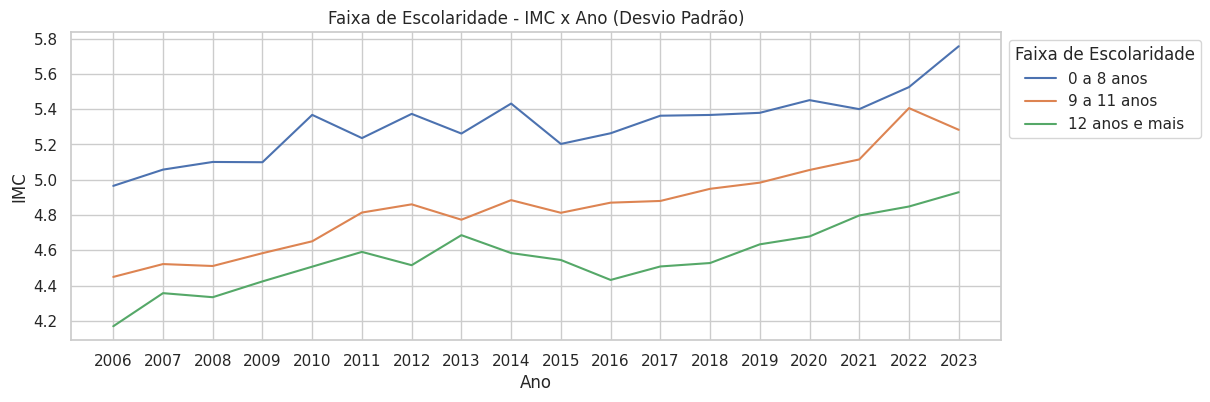

In [ ]:
data0_8Std  = pesquisa[pesquisa["Faixa de Escolaridade"] == "0 a 8 anos"]
data9_11Std   = pesquisa[pesquisa["Faixa de Escolaridade"] == "9 a 11 anos"]
data12MaisStd   = pesquisa[pesquisa["Faixa de Escolaridade"] == "12 anos e mais"]

data0_8Std  = data0_8Std.groupby(["Faixa de Escolaridade", "Ano"])["IMC"].std().reset_index()
data9_11Std   = data9_11Std.groupby(["Faixa de Escolaridade", "Ano"])["IMC"].std().reset_index()
data12MaisStd   = data12MaisStd.groupby(["Faixa de Escolaridade", "Ano"])["IMC"].std().reset_index()

data0_8Std = pd.DataFrame(data0_8Std)
data9_11Std = pd.DataFrame(data9_11Std)
data12MaisStd = pd.DataFrame(data12MaisStd)

#Criação do gráfico de linha para o Genero de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Faixa de Escolaridade - IMC x Ano (Desvio Padrão)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=data0_8Std, x="Ano", y="IMC", label="0 a 8 anos")
sns.lineplot(data=data9_11Std, x="Ano", y="IMC", label="9 a 11 anos")
a = sns.lineplot(data=data12MaisStd, x="Ano", y="IMC", label="12 anos e mais")

plt.legend(title='Faixa de Escolaridade')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(data12MaisStd['Ano'])
plt.show()

# **Média e Desvio Padrão por Exercicio Fisico Anual**

---



---



In [ ]:
AnoExercicioFisicoImcMedia = pd.DataFrame(pesquisa.groupby(["Exercicio Fisico", "Ano"])["IMC"].mean().round(2))
AnoExercicioFisicoImcDesvio = pd.DataFrame(pesquisa.groupby(["Exercicio Fisico", "Ano"])["IMC"].std().round(2))

AnoExercicioFisicoImcData = pd.DataFrame()
AnoExercicioFisicoImcData["Media ± Desvio Padrão"] = AnoExercicioFisicoImcMedia
AnoExercicioFisicoImcData[""] = "±"
AnoExercicioFisicoImcData["Desvio Padrao"] = AnoExercicioFisicoImcDesvio
AnoExercicioFisicoImcData.to_excel('ExercicioFisico_IMC_Media_Desvio.xlsx')

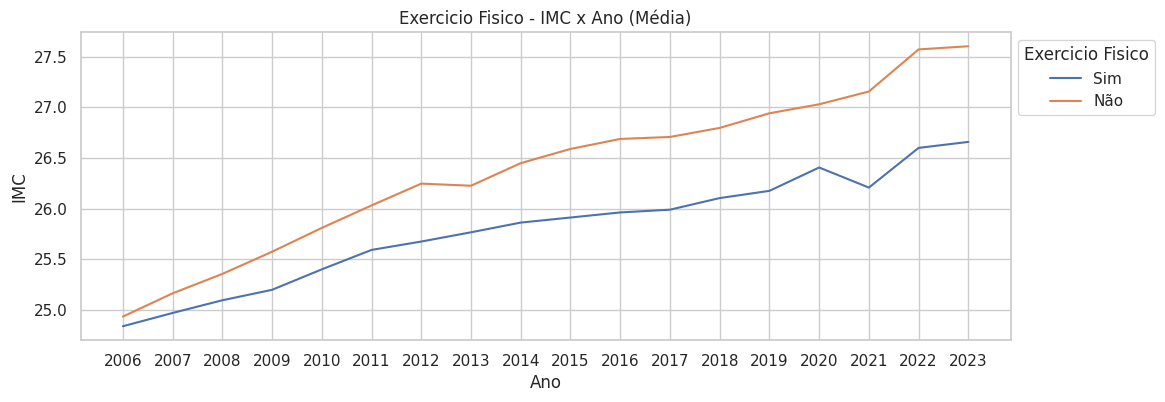

In [ ]:
dataExercicioFisicoSim  = pesquisa[pesquisa["Exercicio Fisico"] == "Sim"]
dataExercicioFisicoNao   = pesquisa[pesquisa["Exercicio Fisico"] == "Não"]

dataExercicioFisicoSim  = dataExercicioFisicoSim.groupby(["Exercicio Fisico", "Ano"])["IMC"].mean().reset_index()
dataExercicioFisicoNao   = dataExercicioFisicoNao.groupby(["Exercicio Fisico", "Ano"])["IMC"].mean().reset_index()

dataExercicioFisicoSim = pd.DataFrame(dataExercicioFisicoSim)
dataExercicioFisicoNao = pd.DataFrame(dataExercicioFisicoNao)

#Criação do gráfico de linha para o Exercicio Fisico de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Exercicio Fisico - IMC x Ano (Média)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=dataExercicioFisicoSim, x="Ano", y="IMC", label="Sim")
a = sns.lineplot(data=dataExercicioFisicoNao, x="Ano", y="IMC", label="Não")

plt.legend(title='Exercicio Fisico')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(dataExercicioFisicoNao['Ano'])
plt.show()

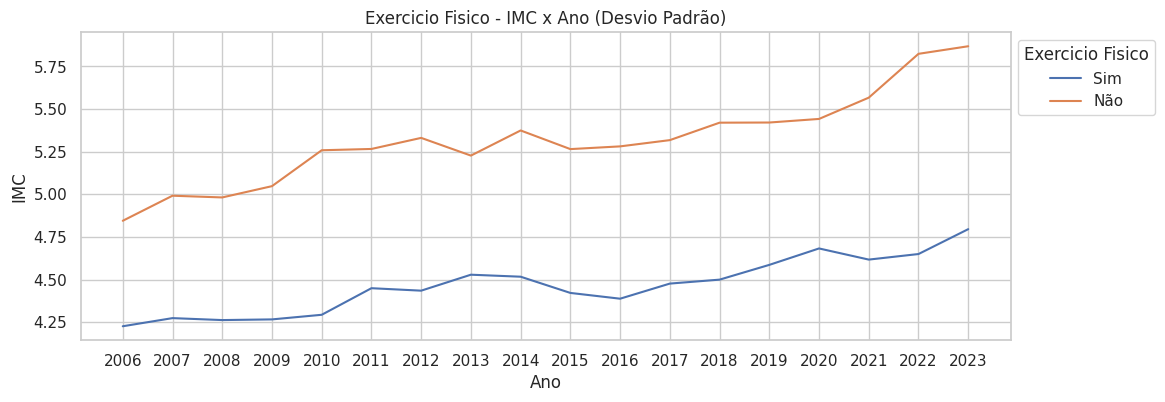

In [ ]:
dataExercicioFisicoSimStd  = pesquisa[pesquisa["Exercicio Fisico"] == "Sim"]
dataExercicioFisicoNaoStd   = pesquisa[pesquisa["Exercicio Fisico"] == "Não"]

dataExercicioFisicoSimStd  = dataExercicioFisicoSimStd.groupby(["Exercicio Fisico", "Ano"])["IMC"].std().reset_index()
dataExercicioFisicoNaoStd   = dataExercicioFisicoNaoStd.groupby(["Exercicio Fisico", "Ano"])["IMC"].std().reset_index()

dataExercicioFisicoSimStd = pd.DataFrame(dataExercicioFisicoSimStd)
dataExercicioFisicoNaoStd = pd.DataFrame(dataExercicioFisicoNaoStd)

#Criação do gráfico de linha para o Exercicio Fisico de IMC por ANO
plt.figure(figsize=(12, 4))
plt.title("Exercicio Fisico - IMC x Ano (Desvio Padrão)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=dataExercicioFisicoSimStd, x="Ano", y="IMC", label="Sim")
a = sns.lineplot(data=dataExercicioFisicoNaoStd, x="Ano", y="IMC", label="Não")

plt.legend(title='Exercicio Fisico')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(dataExercicioFisicoNaoStd['Ano'])
plt.show()

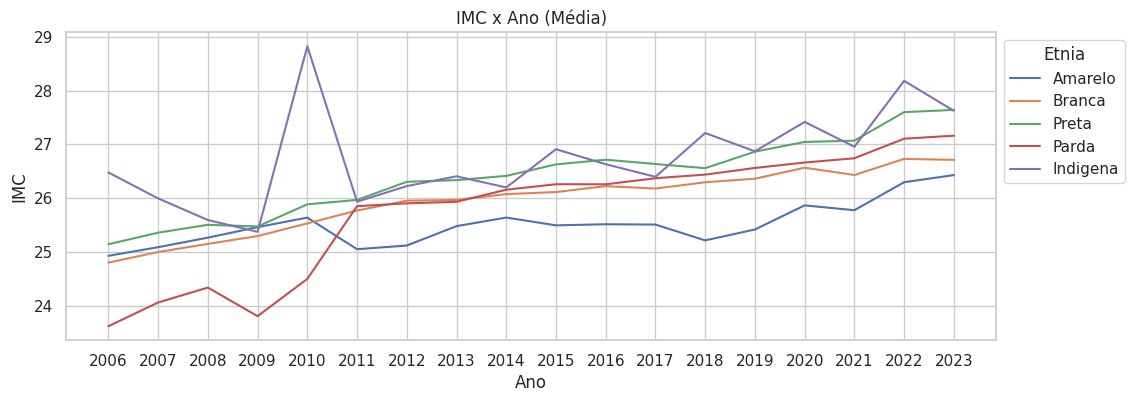

In [ ]:
dataAmarela  = pesquisa.query('Cor == "Amarela"')
dataBranca   = pesquisa.query('Cor == "Branca"')
dataPreta    = pesquisa.query('Cor == "Preta"')
dataParda    = pesquisa.query('Cor == "Parda"')
dataIndigena = pesquisa.query('Cor == "Indígena"')

dataAmarela  = dataAmarela.groupby(["Cor", "Ano"])["IMC"].mean().reset_index()
dataBranca   = dataBranca.groupby(["Cor", "Ano"])["IMC"].mean().reset_index()
dataPreta    = dataPreta.groupby(["Cor", "Ano"])["IMC"].mean().reset_index()
dataParda    = dataParda.groupby(["Cor", "Ano"])["IMC"].mean().reset_index()
dataIndigena = dataIndigena.groupby(["Cor", "Ano"])["IMC"].mean().reset_index()

dataAmarela = pd.DataFrame(dataAmarela)
dataBranca = pd.DataFrame(dataBranca)
dataPreta = pd.DataFrame(dataPreta)
dataParda = pd.DataFrame(dataParda)
dataIndigena = pd.DataFrame(dataIndigena)

#Criação do gráfico de linha para o total de óbitos
plt.figure(figsize=(12, 4))
plt.title("IMC x Ano (Média)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=dataAmarela, x="Ano", y="IMC", label="Amarelo")
sns.lineplot(data=dataBranca, x="Ano", y="IMC", label="Branca")
sns.lineplot(data=dataPreta, x="Ano", y="IMC", label="Preta")
sns.lineplot(data=dataParda, x="Ano", y="IMC", label="Parda")
a = sns.lineplot(data=dataIndigena, x="Ano", y="IMC", label="Indigena")

plt.legend(title='Etnia')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(dataAmarela["Ano"])

plt.show()

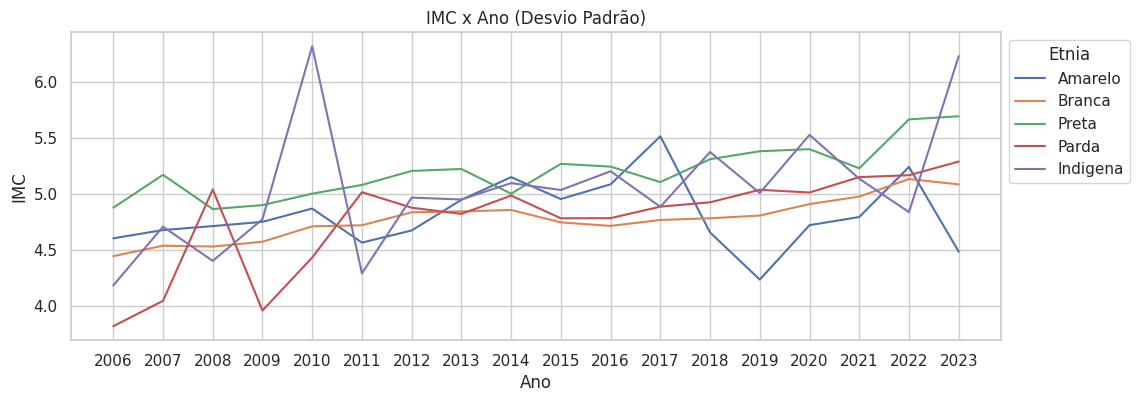

In [ ]:
dataAmarelaStd  = pesquisa.query('Cor == "Amarela"')
dataBrancaStd   = pesquisa.query('Cor == "Branca"')
dataPretaStd    = pesquisa.query('Cor == "Preta"')
dataPardaStd    = pesquisa.query('Cor == "Parda"')
dataIndigenaStd = pesquisa.query('Cor == "Indígena"')

dataAmarelaStd  = dataAmarelaStd.groupby(["Cor", "Ano"])["IMC"].std().reset_index()
dataBrancaStd   = dataBrancaStd.groupby(["Cor", "Ano"])["IMC"].std().reset_index()
dataPretaStd    = dataPretaStd.groupby(["Cor", "Ano"])["IMC"].std().reset_index()
dataPardaStd    = dataPardaStd.groupby(["Cor", "Ano"])["IMC"].std().reset_index()
dataIndigenaStd = dataIndigenaStd.groupby(["Cor", "Ano"])["IMC"].std().reset_index()

dataAmarelaStd = pd.DataFrame(dataAmarelaStd)
dataBrancaStd = pd.DataFrame(dataBrancaStd)
dataPretaStd = pd.DataFrame(dataPretaStd)
dataPardaStd = pd.DataFrame(dataPardaStd)
dataIndigenaStd = pd.DataFrame(dataIndigenaStd)

#Criação do gráfico de linha para o total de óbitos
plt.figure(figsize=(12, 4))
plt.title("IMC x Ano (Desvio Padrão)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=dataAmarelaStd, x="Ano", y="IMC", label="Amarelo")
sns.lineplot(data=dataBrancaStd, x="Ano", y="IMC", label="Branca")
sns.lineplot(data=dataPretaStd, x="Ano", y="IMC", label="Preta")
sns.lineplot(data=dataPardaStd, x="Ano", y="IMC", label="Parda")
a = sns.lineplot(data=dataIndigenaStd, x="Ano", y="IMC", label="Indigena")

plt.legend(title='Etnia')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(dataIndigenaStd["Ano"])

plt.show()

# **Variável dos anos a ter a previsão**

In [ ]:
future = pd.DataFrame({"ds": [2024, 2025, 2026, 2027, 2028, 2029, 2030]})

# **Previsão Temporal de IMC - Anual**

In [ ]:
mAno = Prophet()
result = pesquisa.groupby(["Ano"])["IMC"].mean()

dataPresent = pd.DataFrame()
dataPresent = pd.DataFrame(result)
dataPresent.reset_index(level=0, inplace=True)
dataPresent.rename(columns={"Ano": "ds", "IMC": "y"}, inplace=True)

mAno.fit(dataPresent)

forecastAno = mAno.predict(future)
forecastAno[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

plot_plotly(mAno, forecastAno, xlabel= "Ano", ylabel="IMC")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2360h3dq/v0odnpgl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2360h3dq/pufes94x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28108', 'data', 'file=/tmp/tmp2360h3dq/v0odnpgl.json', 'init=/tmp/tmp2360h3dq/pufes94x.json', 'output', 'file=/tmp/tmp2360h3dq/prophet_modell285rf3p/prophet_model-20240606035358.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:53:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:53:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:

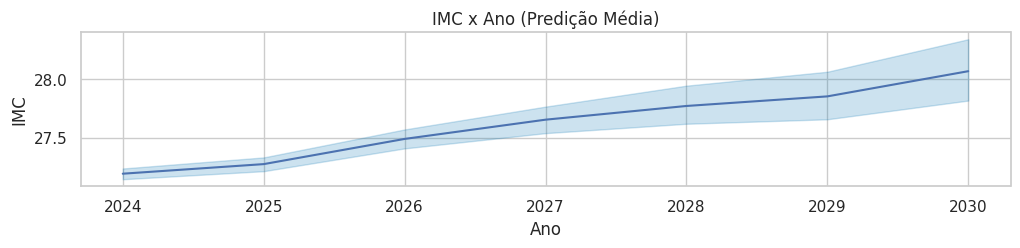

In [ ]:
plt.figure(figsize=(12, 2))
plt.title("IMC x Ano (Predição Média)")
sns.set_theme(style="whitegrid")
forecastAno["ds"] = pd.to_datetime(forecastAno['ds']).dt.strftime('%Y')
forecastAno.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
a = sns.lineplot(data=forecastAno, x="Ano", y="IMC")
a.set(xlabel='Ano', ylabel='IMC')
plt.fill_between(forecastAno["Ano"], forecastAno['yhat_lower'], forecastAno['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.xticks(forecastAno["Ano"])
plt.show()

In [ ]:
forecastAno["Ano"]

0    2024
1    2025
2    2026
3    2027
4    2028
5    2029
6    2030
Name: Ano, dtype: object

In [ ]:
forecastAno2024 = forecastAno[forecastAno["Ano"] == "2024"]
forecastAno2025 = forecastAno[forecastAno["Ano"] == "2025"]
forecastAno2026 = forecastAno[forecastAno["Ano"] == "2026"]
forecastAno2027 = forecastAno[forecastAno["Ano"] == "2027"]
forecastAno2028 = forecastAno[forecastAno["Ano"] == "2028"]
forecastAno2029 = forecastAno[forecastAno["Ano"] == "2029"]
forecastAno2030 = forecastAno[forecastAno["Ano"] == "2030"]

forecastAno2030["IMC"].round(2)

6    28.07
Name: IMC, dtype: float64

In [ ]:
direferencaIncerta = forecastAno2030["yhat_upper"] - forecastAno2030["yhat_lower"]
direferencaIncerta

6    0.52063
dtype: float64

In [ ]:
forecastAno

,Ano,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,IMC
0,2024,1.464988,27.148503,27.239860,1.454506,1.475534,25.730636,25.730636,25.730636,25.730636,25.730636,25.730636,0.0,0.0,0.0,27.195624
1,2025,1.609036,27.216957,27.333867,1.575074,1.642492,25.667969,25.667969,25.667969,25.667969,25.667969,25.667969,0.0,0.0,0.0,27.277004
2,2026,1.752690,27.410315,27.571221,1.686092,1.818639,25.738165,25.738165,25.738165,25.738165,25.738165,25.738165,0.0,0.0,0.0,27.490854
3,2027,1.896344,27.539898,27.765107,1.795659,2.001970,25.757906,25.757906,25.757906,25.757906,25.757906,25.757906,0.0,0.0,0.0,27.654250
4,2028,2.039998,27.619479,27.942934,1.897941,2.192880,25.730636,25.730636,25.730636,25.730636,25.730636,25.730636,0.0,0.0,0.0,27.770634
5,2029,2.184045,27.657576,28.061217,1.999532,2.389241,25.667969,25.667969,25.667969,25.667969,25.667969,25.667969,0.0,0.0,0.0,27.852014
6,2030,2.327699,27.816495,28.337125,2.078012,2.588422,25.738165,25.738165,25.738165,25.738165,25.738165,25.738165,0.0,0.0,0.0,28.065864


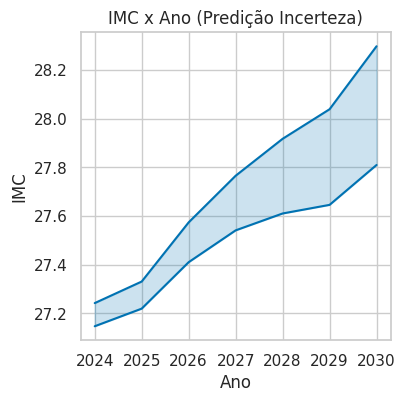

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")
sns.lineplot(data=forecastAno, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastAno, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')
plt.fill_between(forecastAno["Ano"], forecastAno['yhat_lower'], forecastAno['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

[Text(0.5, 1.0, 'y train-test split '),
 Text(0.5, 0, 'ANO'),
 Text(0, 0.5, 'IMC')]

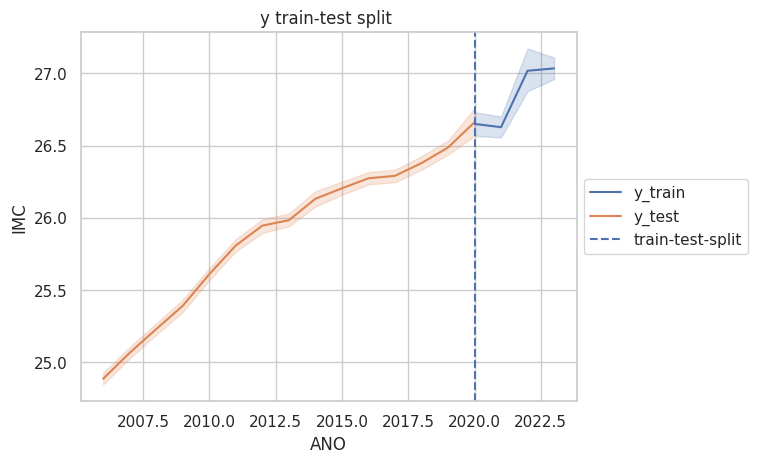

In [ ]:
AnoImcMediaPrev = pd.DataFrame()
AnoImcMediaPrev["ds"] = pesquisa["Ano"]
AnoImcMediaPrev["y"] = pesquisa["IMC"]
AnoImcMediaPrev

present = pesquisa.groupby(["Ano"])["IMC"].mean()
x = AnoImcMediaPrev["ds"].values.T
y = AnoImcMediaPrev["y"].values.T
n = len(AnoImcMediaPrev)


prop_train = 0.08
n_train = round(prop_train * n)


x_train = x[:n_train]
y_train = y[:n_train]
x_test = x[n_train:]
y_test = y[n_train:]



# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='ANO', ylabel='IMC')


[Text(0.5, 1.0, 'y train-test split '),
 Text(0.5, 0, 'ANO'),
 Text(0, 0.5, 'IMC')]

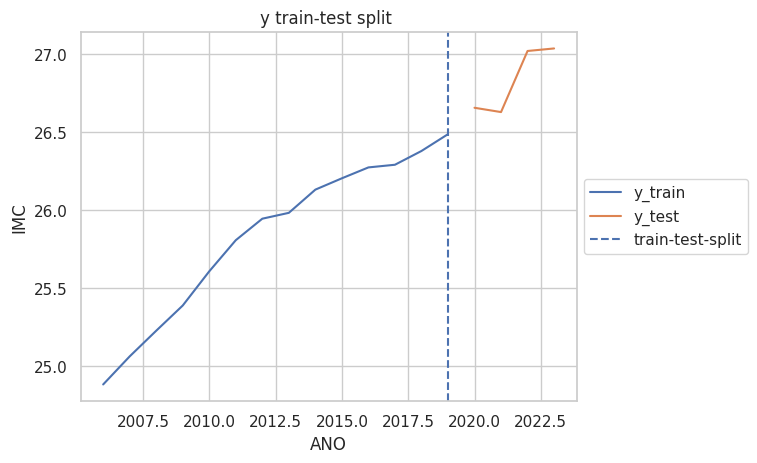

In [ ]:
present = pesquisa.groupby(["Ano"])["IMC"].mean()
x = present.index.values.T
y = present.values.T
n = len(present)

prop_train = 0.8
n_train = round(prop_train * n)


x_train = x[:n_train]
y_train = y[:n_train]
x_test = x[n_train:]
y_test = y[n_train:]



# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='ANO', ylabel='IMC')


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf795btuh/f_c4ptoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf795btuh/lxzw5vwh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77607', 'data', 'file=/tmp/tmpf795btuh/f_c4ptoq.json', 'init=/tmp/tmpf795btuh/lxzw5vwh.json', 'output', 'file=/tmp/tmpf795btuh/prophet_model8zgcxhbt/prophet_model-20240531200411.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:

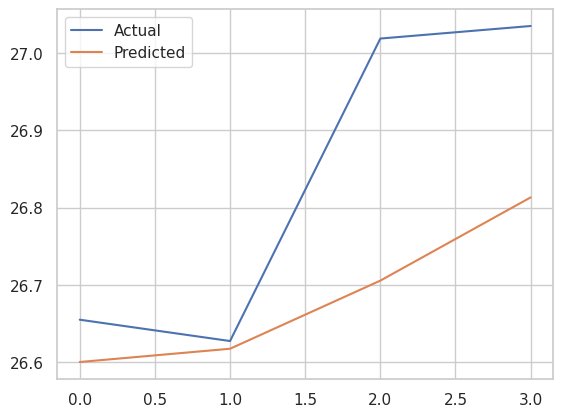

0.14976238359763983

In [ ]:
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

train = dataPresent.drop(dataPresent.index[-4:])
train

mt = Prophet()
mt.fit(train)

futurePredict = pd.DataFrame({"ds": [2020, 2021, 2022, 2023]})
forecastmean = mt.predict(futurePredict)

last4DataPresent = dataPresent.iloc[-4:]
y_true = dataPresent["y"][-4:].values
y_pred = forecastmean["yhat"].values
mae = mean_absolute_error(y_true, y_pred)
forecastmean['ds'] = pd.to_datetime(forecastmean['ds']).dt.strftime('%Y')
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()
mae

# plt.figure(figsize=(12, 4))
# plt.title("IMC x Ano (Média)")
# sns.set_theme(style="whitegrid")

# sns.lineplot(data=last4DataPresent, x="ds", y="y", label="Atual")
# sns.lineplot(data=forecast, x="ds", y="yhat", label="Previsão")

# # plt.legend(title='Etnia')
# # sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

# plt.xticks(forecast["ds"])
# plt.show()

# mae = mean_absolute_error(y_true, y_pred)
# mae

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020,18.014441,26.569370,26.628640,17.983392,18.042661,8.585978,8.585978,8.585978,8.585978,8.585978,8.585978,0.0,0.0,0.0,26.600420
1,2021,18.096377,26.520341,26.708506,17.999159,18.187324,8.521183,8.521183,8.521183,8.521183,8.521183,8.521183,0.0,0.0,0.0,26.617559
2,2022,18.178088,26.525082,26.877918,17.997555,18.350392,8.527527,8.527527,8.527527,8.527527,8.527527,8.527527,0.0,0.0,0.0,26.705614
3,2023,18.259799,26.522299,27.077342,17.968916,18.523959,8.553383,8.553383,8.553383,8.553383,8.553383,8.553383,0.0,0.0,0.0,26.813182


# **Previsão Temporal de Estado de Saúde - Anual**

### Previsão Temporal de Estado de Saúde - Muito Ruim

In [ ]:
m = Prophet()
m2 = Prophet()
m3 = Prophet()
m4 = Prophet()
m5 = Prophet()

presMuitoRuim = pd.DataFrame()
presMuitoRuim["ds"] = dataMuitoRuim['Ano']
presMuitoRuim["y"] = dataMuitoRuim['IMC']

m.fit(presMuitoRuim)

forecastMuitoRuim = m.predict(future)
forecastMuitoRuim[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

presRuim = pd.DataFrame()
presRuim["ds"] = dataRuim['Ano']
presRuim["y"] = dataRuim['IMC']

m2.fit(presRuim)

forecastRuim = m2.predict(future)
forecastRuim[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

m3 = Prophet()

presRegular = pd.DataFrame()
presRegular["ds"] = dataRegular['Ano']
presRegular["y"] = dataRegular['IMC']

m3.fit(presRegular)

forecastRegular = m3.predict(future)
forecastRegular[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

m4 = Prophet()

presBom = pd.DataFrame()
presBom["ds"] = dataBom['Ano']
presBom["y"] = dataBom['IMC']

m4.fit(presBom)

forecastBom = m4.predict(future)
forecastBom[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

m5 = Prophet()

presMuitoBom = pd.DataFrame()
presMuitoBom["ds"] = dataMuitoBom['Ano']
presMuitoBom["y"] = dataMuitoBom['IMC']

m5.fit(presMuitoBom)

forecastMuitoBom = m5.predict(future)
forecastMuitoBom[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecastMuitoRuim["ds"] = pd.to_datetime(forecastMuitoRuim['ds']).dt.strftime('%Y')
forecastRuim["ds"] = pd.to_datetime(forecastRuim['ds']).dt.strftime('%Y')
forecastRegular["ds"] = pd.to_datetime(forecastRegular['ds']).dt.strftime('%Y')
forecastBom["ds"] = pd.to_datetime(forecastBom['ds']).dt.strftime('%Y')
forecastMuitoBom["ds"] = pd.to_datetime(forecastMuitoBom['ds']).dt.strftime('%Y')


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/pbs2h_m3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/2ke87j5d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32862', 'data', 'file=/tmp/tmpf9ehukyz/pbs2h_m3.json', 'init=/tmp/tmpf9ehukyz/2ke87j5d.json', 'output', 'file=/tmp/tmpf9ehukyz/prophet_modelg1btemcd/prophet_model-20240601004256.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:42:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:

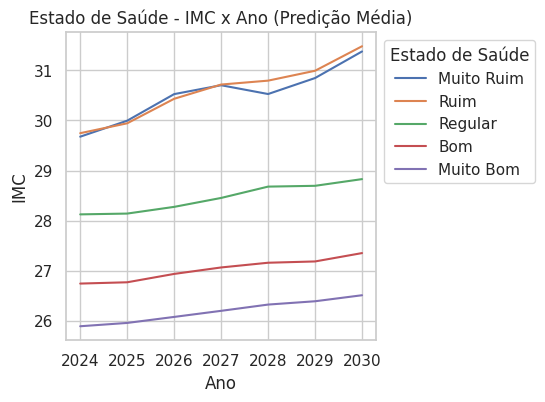

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Estado de Saúde - IMC x Ano (Predição Média)")
sns.set_theme(style="whitegrid")

forecastMuitoRuim.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastRuim.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastRegular.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastBom.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastMuitoBom.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)

sns.lineplot(data=forecastMuitoRuim, x="Ano", y="IMC", label ="Muito Ruim")
sns.lineplot(data=forecastRuim, x="Ano", y="IMC", label ="Ruim")
sns.lineplot(data=forecastRegular, x="Ano", y="IMC", label ="Regular")
sns.lineplot(data=forecastBom, x="Ano", y="IMC", label ="Bom")
a = sns.lineplot(data=forecastMuitoBom, x="Ano", y="IMC", label ="Muito Bom")

plt.legend(title='Estado de Saúde')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(forecastMuitoBom["Ano"])
plt.show()

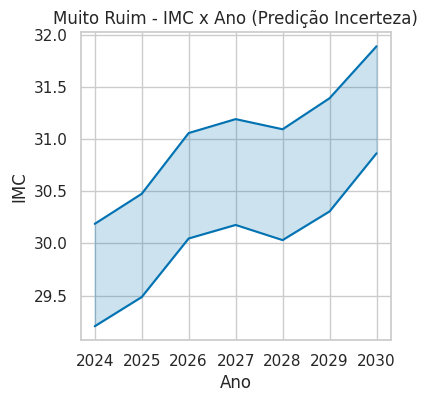

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Muito Ruim - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastMuitoRuim, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastMuitoRuim, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastMuitoRuim["Ano"], forecastMuitoRuim['yhat_lower'], forecastMuitoRuim['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()


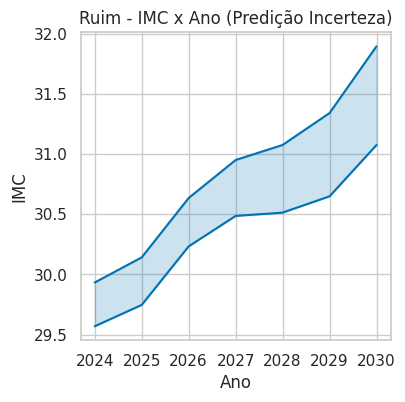

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Ruim - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastRuim, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastRuim, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastRuim["Ano"], forecastRuim['yhat_lower'], forecastRuim['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()



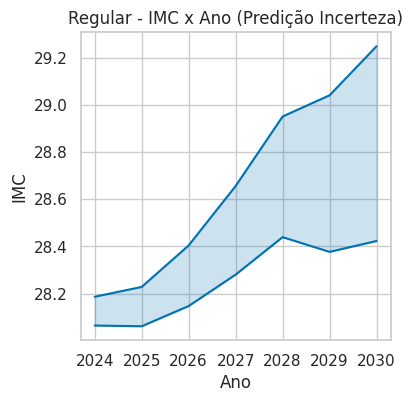

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Regular - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastRegular, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastRegular, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastRegular["Ano"], forecastRegular['yhat_lower'], forecastRegular['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()


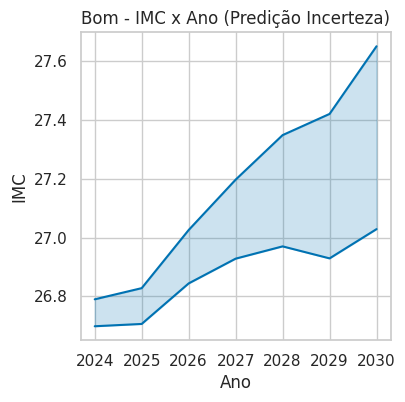

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Bom - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastBom, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastBom, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastBom["Ano"], forecastBom['yhat_lower'], forecastBom['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

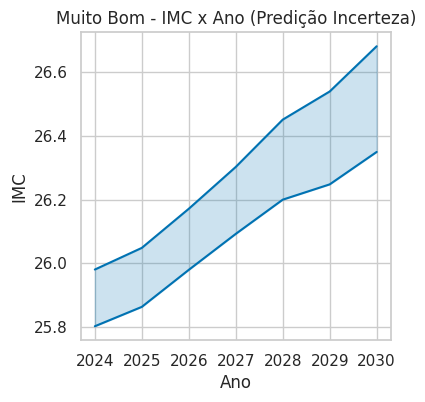

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Muito Bom - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastMuitoBom, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastMuitoBom, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastMuitoBom["Ano"], forecastMuitoBom['yhat_lower'], forecastMuitoBom['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

# **Previsão Temporal por Região - Anual x IMC**

In [ ]:
mSul = Prophet()
mSudeste = Prophet()
mCentroOeste = Prophet()
mNordeste = Prophet()
mNorte = Prophet()

#Predição SUL
presSul = pd.DataFrame()
presSul["ds"] = dataSul['Ano']
presSul["y"] = dataSul['IMC']

mSul.fit(presSul)

forecastSul = mSul.predict(future)
forecastSul[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Sudeste
presSudeste = pd.DataFrame()
presSudeste["ds"] = dataSudeste['Ano']
presSudeste["y"] = dataSudeste['IMC']

mSudeste.fit(presSudeste)

forecastSudeste = mSudeste.predict(future)
forecastSudeste[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Centro Oeste
presCentroOeste = pd.DataFrame()
presCentroOeste["ds"] = dataCentroOeste['Ano']
presCentroOeste["y"] = dataCentroOeste['IMC']

mCentroOeste.fit(presCentroOeste)

forecastCentroOeste = mCentroOeste.predict(future)
forecastCentroOeste[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Nordeste
presNordeste = pd.DataFrame()
presNordeste["ds"] = dataNordeste['Ano']
presNordeste["y"] = dataNordeste['IMC']

mNordeste.fit(presNordeste)

forecastNordeste = mNordeste.predict(future)
forecastNordeste[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Norte
presNorte = pd.DataFrame()
presNorte["ds"] = dataNorte['Ano']
presNorte["y"] = dataNorte['IMC']

mNorte.fit(presNorte)

forecastNorte = mNorte.predict(future)
forecastNorte[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecastSul["ds"] = pd.to_datetime(forecastSul['ds']).dt.strftime('%Y')
forecastSudeste["ds"] = pd.to_datetime(forecastSudeste['ds']).dt.strftime('%Y')
forecastCentroOeste["ds"] = pd.to_datetime(forecastCentroOeste['ds']).dt.strftime('%Y')
forecastNordeste["ds"] = pd.to_datetime(forecastNordeste['ds']).dt.strftime('%Y')
forecastNorte["ds"] = pd.to_datetime(forecastNorte['ds']).dt.strftime('%Y')


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/m7f1mnwt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/xgw_tpsd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94113', 'data', 'file=/tmp/tmpf9ehukyz/m7f1mnwt.json', 'init=/tmp/tmpf9ehukyz/xgw_tpsd.json', 'output', 'file=/tmp/tmpf9ehukyz/prophet_modelry1j5xri/prophet_model-20240601004109.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:41:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:

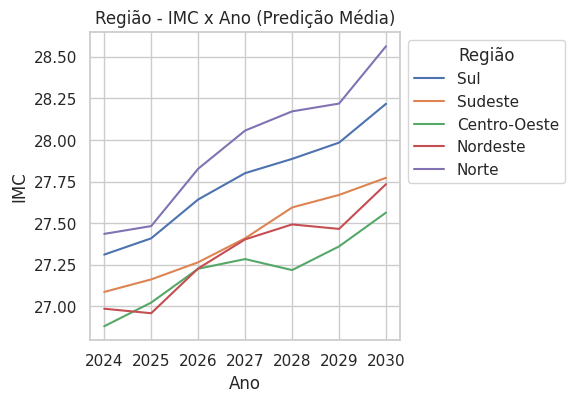

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Região - IMC x Ano (Predição Média)")
sns.set_theme(style="whitegrid")


forecastSul.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastSudeste.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastCentroOeste.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastNordeste.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastNorte.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)

sns.lineplot(data=forecastSul, x="Ano", y="IMC", label ="Sul")
sns.lineplot(data=forecastSudeste, x="Ano", y="IMC", label ="Sudeste")
sns.lineplot(data=forecastCentroOeste, x="Ano", y="IMC", label ="Centro-Oeste")
sns.lineplot(data=forecastNordeste, x="Ano", y="IMC", label ="Nordeste")
a = sns.lineplot(data=forecastNorte, x="Ano", y="IMC", label ="Norte")

plt.legend(title='Região')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(forecastNorte["Ano"])
plt.show()

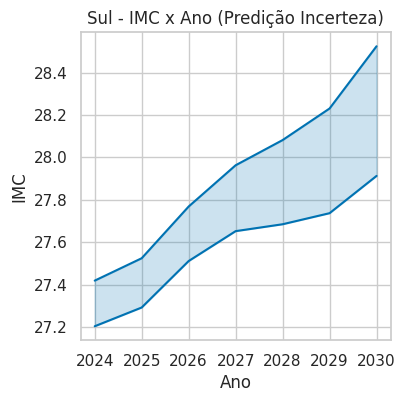

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Sul - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastSul, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastSul, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastSul["Ano"], forecastSul['yhat_lower'], forecastSul['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

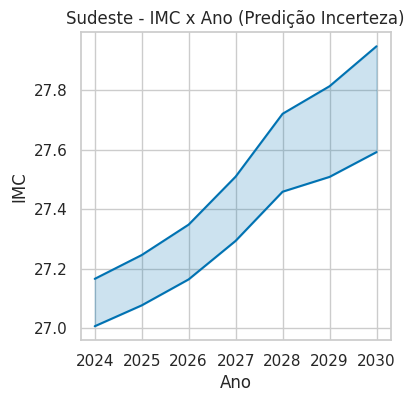

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Sudeste - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastSudeste, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastSudeste, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastSudeste["Ano"], forecastSudeste['yhat_lower'], forecastSudeste['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

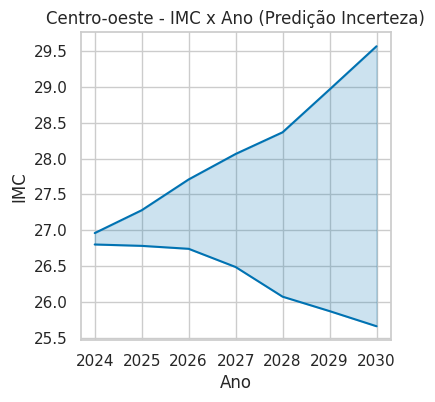

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Centro-oeste - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastCentroOeste, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastCentroOeste, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastCentroOeste["Ano"], forecastCentroOeste['yhat_lower'], forecastCentroOeste['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

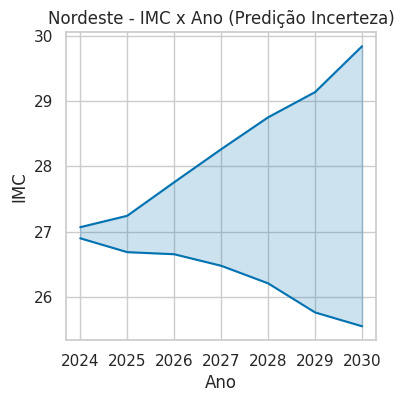

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Nordeste - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastNordeste, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastNordeste, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastNordeste["Ano"], forecastNordeste['yhat_lower'], forecastNordeste['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

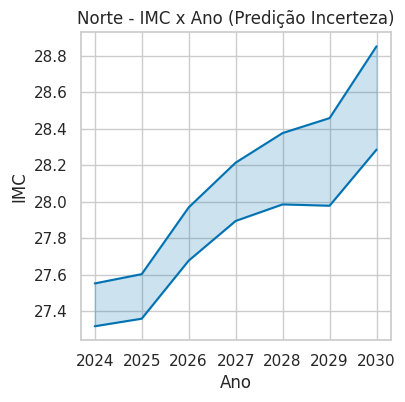

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Norte - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastNorte, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastNorte, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastNorte["Ano"], forecastNorte['yhat_lower'], forecastNorte['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

# **Previsão Temporal por Faixa Etária - Anual x IMC**

In [ ]:
m18_24 = Prophet()
m25_34 = Prophet()
m35_44 = Prophet()
m45_54 = Prophet()
m55_64 = Prophet()
m65Mais = Prophet()

#Predição 18 á 24
pres18_24 = pd.DataFrame()
pres18_24["ds"] = data18_24['Ano']
pres18_24["y"] = data18_24['IMC']

m18_24.fit(pres18_24)

forecast18_24 = m18_24.predict(future)
forecast18_24[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição 25 á 34
pres25_34 = pd.DataFrame()
pres25_34["ds"] = data25_34['Ano']
pres25_34["y"] = data25_34['IMC']

m25_34.fit(pres25_34)

forecast25_34 = m25_34.predict(future)
forecast25_34[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição 35 á 44
pres35_44 = pd.DataFrame()
pres35_44["ds"] = dataCentroOeste['Ano']
pres35_44["y"] = dataCentroOeste['IMC']

m35_44.fit(pres35_44)

forecast35_44 = m35_44.predict(future)
forecast35_44[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição 45 a 54
pres45_54 = pd.DataFrame()
pres45_54["ds"] = data45_54['Ano']
pres45_54["y"] = data45_54['IMC']

m45_54.fit(pres45_54)

forecast45_54 = m45_54.predict(future)
forecast45_54[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição 55 a 64
pres55_64 = pd.DataFrame()
pres55_64["ds"] = data55_64['Ano']
pres55_64["y"] = data55_64['IMC']

m55_64.fit(pres55_64)

forecast55_64 = m55_64.predict(future)
forecast55_64[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição 65+
pres65Mais = pd.DataFrame()
pres65Mais["ds"] = data65Mais['Ano']
pres65Mais["y"] = data65Mais['IMC']

m65Mais.fit(pres65Mais)

forecast65Mais = m65Mais.predict(future)
forecast65Mais[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecast18_24["ds"] = pd.to_datetime(forecast18_24['ds']).dt.strftime('%Y')
forecast25_34["ds"] = pd.to_datetime(forecast25_34['ds']).dt.strftime('%Y')
forecast35_44["ds"] = pd.to_datetime(forecast35_44['ds']).dt.strftime('%Y')
forecast45_54["ds"] = pd.to_datetime(forecast45_54['ds']).dt.strftime('%Y')
forecast55_64["ds"] = pd.to_datetime(forecast55_64['ds']).dt.strftime('%Y')
forecast65Mais["ds"] = pd.to_datetime(forecast65Mais['ds']).dt.strftime('%Y')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/pq4mwzv_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/mexkwirg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10416', 'data', 'file=/tmp/tmpf9ehukyz/pq4mwzv_.json', 'init=/tmp/tmpf9ehukyz/mexkwirg.json', 'output', 'file=/tmp/tmpf9ehukyz/prophet_modeloafnfn21/prophet_model-20240601010648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:06:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:06:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:

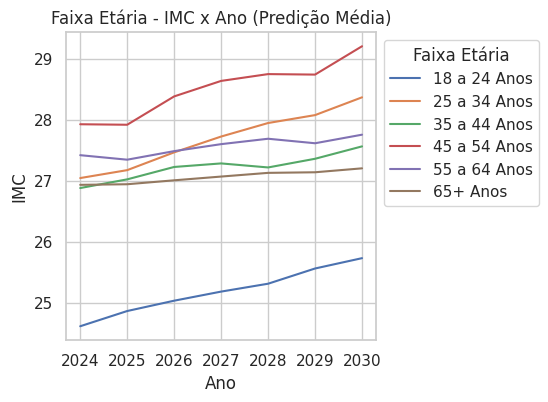

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Faixa Etária - IMC x Ano (Predição Média)")
sns.set_theme(style="whitegrid")

forecast18_24.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecast25_34.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecast35_44.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecast45_54.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecast55_64.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecast65Mais.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)

sns.lineplot(data=forecast18_24, x="Ano", y="IMC", label ="18 a 24 Anos")
sns.lineplot(data=forecast25_34, x="Ano", y="IMC", label ="25 a 34 Anos")
sns.lineplot(data=forecast35_44, x="Ano", y="IMC", label ="35 a 44 Anos")
sns.lineplot(data=forecast45_54, x="Ano", y="IMC", label ="45 a 54 Anos")
sns.lineplot(data=forecast55_64, x="Ano", y="IMC", label ="55 a 64 Anos")
a = sns.lineplot(data=forecast65Mais, x="Ano", y="IMC", label ="65+ Anos")

plt.legend(title='Faixa Etária')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(forecast65Mais["Ano"])
plt.show()

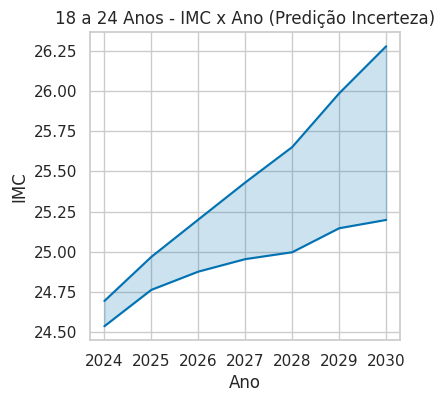

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("18 a 24 Anos - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecast18_24, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecast18_24, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecast18_24["Ano"], forecast18_24['yhat_lower'], forecast18_24['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

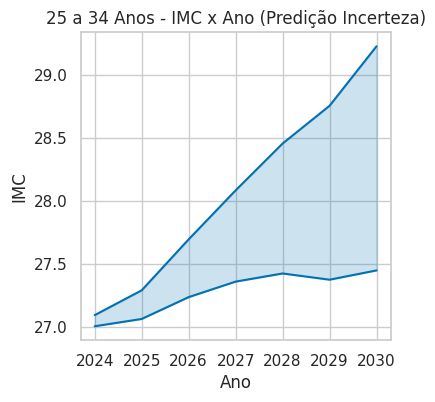

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("25 a 34 Anos - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecast25_34, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecast25_34, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecast25_34["Ano"], forecast25_34['yhat_lower'], forecast25_34['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

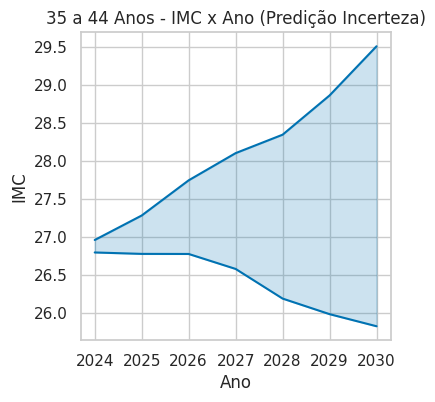

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("35 a 44 Anos - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecast35_44, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecast35_44, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecast35_44["Ano"], forecast35_44['yhat_lower'], forecast35_44['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

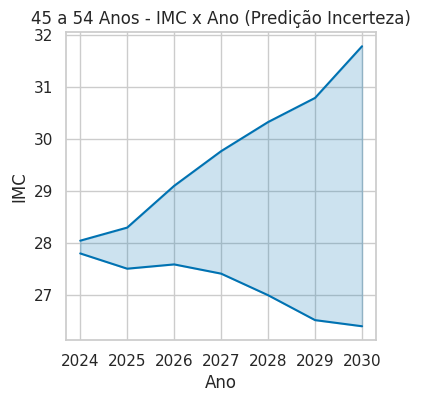

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("45 a 54 Anos - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecast45_54, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecast45_54, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecast45_54["Ano"], forecast45_54['yhat_lower'], forecast45_54['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

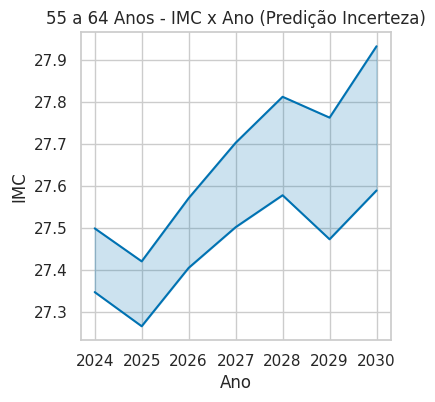

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("55 a 64 Anos - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecast55_64, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecast55_64, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecast55_64["Ano"], forecast55_64['yhat_lower'], forecast55_64['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

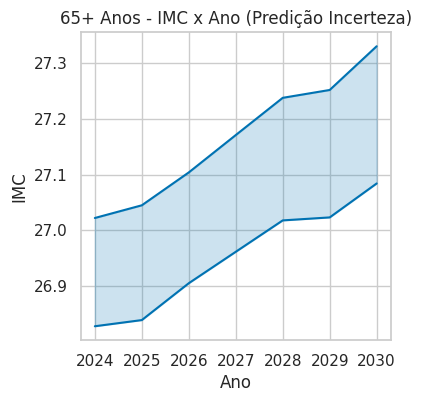

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("65+ Anos - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecast65Mais, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecast65Mais, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecast65Mais["Ano"], forecast65Mais['yhat_lower'], forecast65Mais['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

# **Previsão Temporal por Gênero - Anual x IMC**

In [ ]:
mFeminino = Prophet()
mMasculino = Prophet()

#Predição Feminino
presFeminino = pd.DataFrame()
presFeminino["ds"] = dataFeminino['Ano']
presFeminino["y"] = dataFeminino['IMC']

mFeminino.fit(presFeminino)

forecastFeminino = mFeminino.predict(future)
forecastFeminino[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Masculino
presMasculino = pd.DataFrame()
presMasculino["ds"] = dataMasculino['Ano']
presMasculino["y"] = dataMasculino['IMC']

mMasculino.fit(presMasculino)

forecastMasculino = mMasculino.predict(future)
forecastMasculino[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


forecastFeminino["ds"] = pd.to_datetime(forecastFeminino['ds']).dt.strftime('%Y')
forecastMasculino["ds"] = pd.to_datetime(forecastMasculino['ds']).dt.strftime('%Y')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/9lmntq_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/4xbxfo2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85520', 'data', 'file=/tmp/tmpf9ehukyz/9lmntq_1.json', 'init=/tmp/tmpf9ehukyz/4xbxfo2w.json', 'output', 'file=/tmp/tmpf9ehukyz/prophet_modelj_arfadd/prophet_model-20240601011021.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:10:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:

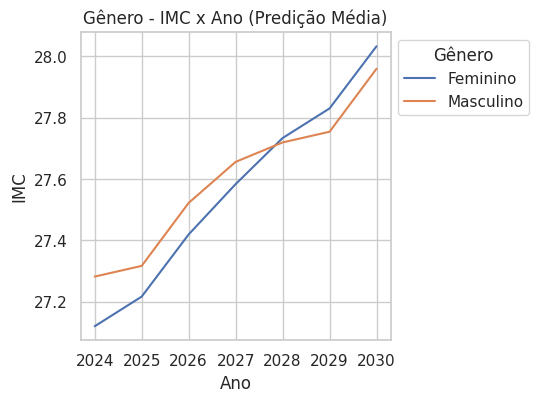

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Gênero - IMC x Ano (Predição Média)")
sns.set_theme(style="whitegrid")

forecastFeminino.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastMasculino.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)

sns.lineplot(data=forecastFeminino, x="Ano", y="IMC", label ="Feminino")
a = sns.lineplot(data=forecastMasculino, x="Ano", y="IMC", label ="Masculino")

plt.legend(title='Gênero')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(forecastMasculino["Ano"])
plt.show()

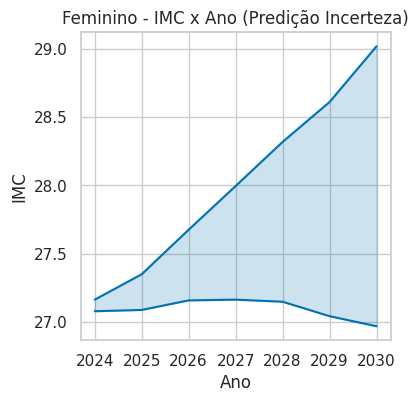

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Feminino - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastFeminino, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastFeminino, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastFeminino["Ano"], forecastFeminino['yhat_lower'], forecastFeminino['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

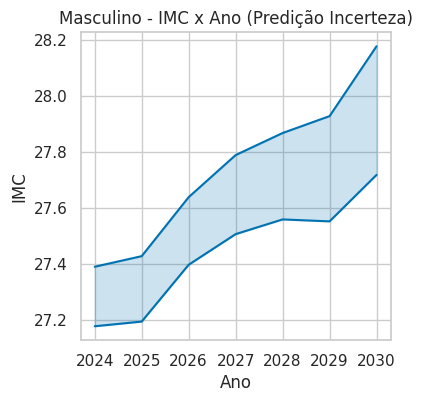

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Masculino - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastMasculino, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastMasculino, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastMasculino["Ano"], forecastMasculino['yhat_lower'], forecastMasculino['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

# **Previsão Temporal por Escolaridade - Anual x IMC**

In [ ]:
m0_8 = Prophet()
m9_11 = Prophet()
m12mais = Prophet()

#Predição Escolaridade 0 a 8 anos
pres0_8 = pd.DataFrame()
pres0_8["ds"] = data0_8['Ano']
pres0_8["y"] = data0_8['IMC']

m0_8.fit(pres0_8)

forecast0_8 = m0_8.predict(future)
forecast0_8[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Escolaridade 9 a 11 anos
pres9_11 = pd.DataFrame()
presMasculino["ds"] = data9_11['Ano']
presMasculino["y"] = data9_11['IMC']

m9_11.fit(presMasculino)

forecast9_11 = m9_11.predict(future)
forecast9_11[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Escolaridade 12+
pres12mais = pd.DataFrame()
pres12mais["ds"] = data12Mais['Ano']
pres12mais["y"] = data12Mais['IMC']

m12mais.fit(pres12mais)

forecast12mais = m12mais.predict(future)
forecast12mais[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


forecast0_8["ds"] = pd.to_datetime(forecast0_8['ds']).dt.strftime('%Y')
forecast9_11["ds"] = pd.to_datetime(forecast9_11['ds']).dt.strftime('%Y')
forecast12mais["ds"] = pd.to_datetime(forecast12mais['ds']).dt.strftime('%Y')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/vblj4dou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/at6be1bz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74333', 'data', 'file=/tmp/tmpf9ehukyz/vblj4dou.json', 'init=/tmp/tmpf9ehukyz/at6be1bz.json', 'output', 'file=/tmp/tmpf9ehukyz/prophet_modelkj3gylzj/prophet_model-20240601011411.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:14:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:14:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:

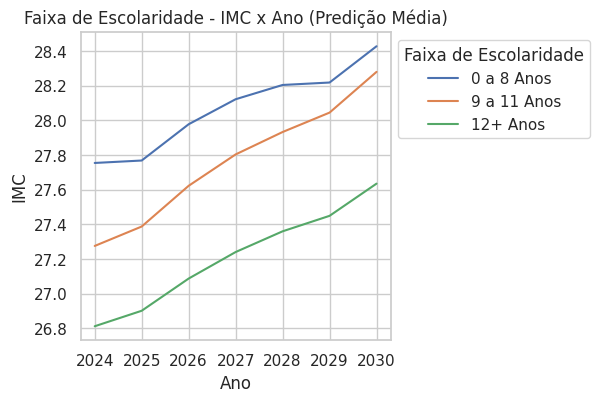

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Faixa de Escolaridade - IMC x Ano (Predição Média)")
sns.set_theme(style="whitegrid")

forecast0_8.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecast9_11.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecast12mais.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)

sns.lineplot(data=forecast0_8, x="Ano", y="IMC", label ="0 a 8 Anos")
sns.lineplot(data=forecast9_11, x="Ano", y="IMC", label ="9 a 11 Anos")
a = sns.lineplot(data=forecast12mais, x="Ano", y="IMC", label ="12+ Anos")

plt.legend(title='Faixa de Escolaridade')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(forecast12mais["Ano"])
plt.show()

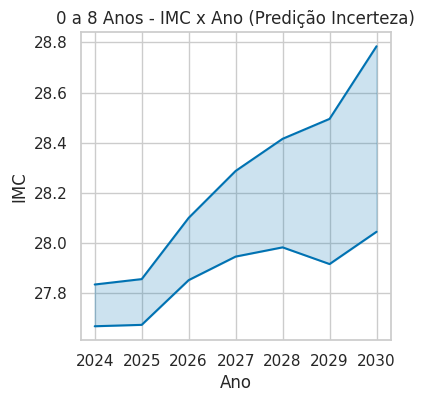

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("0 a 8 Anos - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecast0_8, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecast0_8, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecast0_8["Ano"], forecast0_8['yhat_lower'], forecast0_8['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

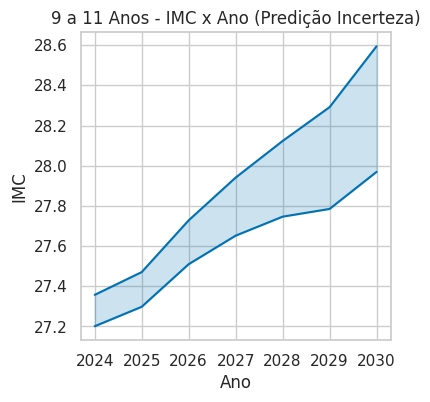

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("9 a 11 Anos - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecast9_11, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecast9_11, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecast9_11["Ano"], forecast9_11['yhat_lower'], forecast9_11['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

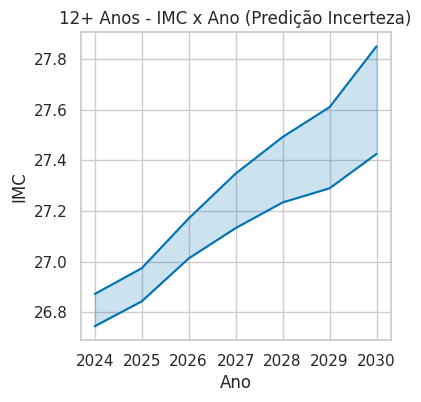

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("12+ Anos - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecast12mais, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecast12mais, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecast12mais["Ano"], forecast12mais['yhat_lower'], forecast12mais['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

# **Previsão Temporal por Exercicio Fisico - Anual x IMC**


In [ ]:
mEFSim = Prophet()
mEFNao = Prophet()

#Predição Exercicio Fisico - Sim
presEFSim = pd.DataFrame()
presEFSim["ds"] = dataExercicioFisicoSim['Ano']
presEFSim["y"] = dataExercicioFisicoSim['IMC']

mEFSim.fit(presEFSim)

forecastEFSim = mEFSim.predict(future)
forecastEFSim[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Exercicio Fisico - Não
presEFNao = pd.DataFrame()
presEFNao["ds"] = dataExercicioFisicoNao['Ano']
presEFNao["y"] = dataExercicioFisicoNao['IMC']

mEFNao.fit(presEFNao)

forecastEFNao = mEFNao.predict(future)
forecastEFNao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


forecastEFSim["ds"] = pd.to_datetime(forecastEFSim['ds']).dt.strftime('%Y')
forecastEFNao["ds"] = pd.to_datetime(forecastEFNao['ds']).dt.strftime('%Y')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/h81qi8k8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/cjo4lz95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1156', 'data', 'file=/tmp/tmpf9ehukyz/h81qi8k8.json', 'init=/tmp/tmpf9ehukyz/cjo4lz95.json', 'output', 'file=/tmp/tmpf9ehukyz/prophet_modeleulc4424/prophet_model-20240601011623.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:16:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:16:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

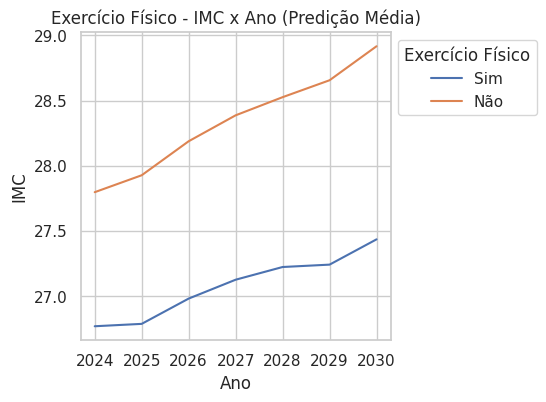

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Exercício Físico - IMC x Ano (Predição Média)")
sns.set_theme(style="whitegrid")

forecastEFSim.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastEFNao.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)

sns.lineplot(data=forecastEFSim, x="Ano", y="IMC", label ="Sim")
a = sns.lineplot(data=forecastEFNao, x="Ano", y="IMC", label ="Não")

plt.legend(title='Exercício Físico')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(forecastEFNao["Ano"])
plt.show()

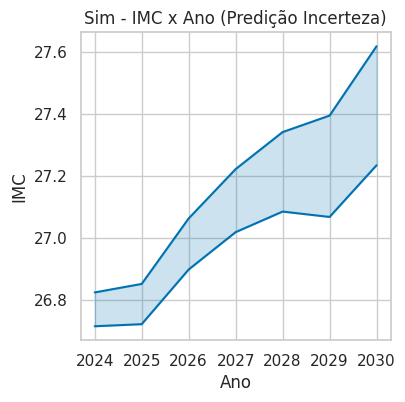

In [ ]:
forecastEFSim.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
plt.figure(figsize=(4, 4))
plt.title("Sim - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastEFSim, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastEFSim, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastEFSim["Ano"], forecastEFSim['yhat_lower'], forecastEFSim['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

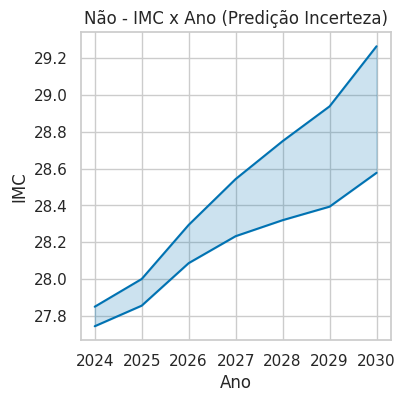

In [ ]:
forecastEFNao.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
plt.figure(figsize=(4, 4))
plt.title("Não - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastEFNao, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastEFNao, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastEFNao["Ano"], forecastEFNao['yhat_lower'], forecastEFNao['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

# **Previsão Temporal por Etnia - Anual x IMC**


In [ ]:
mAmarela = Prophet()
mBranca = Prophet()
mPreta = Prophet()
mParda = Prophet()
mIndigena = Prophet()

#Predição Amarela
presAmarela = pd.DataFrame()
presAmarela["ds"] = dataAmarela['Ano']
presAmarela["y"] = dataAmarela['IMC']

mAmarela.fit(presAmarela)

forecastAmarela = mAmarela.predict(future)
forecastAmarela[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Branca
presBranca = pd.DataFrame()
presBranca["ds"] = dataBranca['Ano']
presBranca["y"] = dataBranca['IMC']

mBranca.fit(presBranca)

forecastBranca = mBranca.predict(future)
forecastBranca[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Preta
presPreta = pd.DataFrame()
presPreta["ds"] = dataPreta['Ano']
presPreta["y"] = dataPreta['IMC']

mPreta.fit(presPreta)

forecastPreta = mPreta.predict(future)
forecastPreta[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Parda
presParda = pd.DataFrame()
presParda["ds"] = dataParda['Ano']
presParda["y"] = dataParda['IMC']

mParda.fit(presParda)

forecastParda = mParda.predict(future)
forecastParda[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Predição Indigena
presIndigena = pd.DataFrame()
presIndigena["ds"] = dataIndigena['Ano']
presIndigena["y"] = dataIndigena['IMC']

mIndigena.fit(presIndigena)

forecastIndigena = mIndigena.predict(future)
forecastIndigena[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Trocando dia/mes/ano para Ano
forecastAmarela["ds"] = pd.to_datetime(forecastAmarela['ds']).dt.strftime('%Y')
forecastBranca["ds"] = pd.to_datetime(forecastBranca['ds']).dt.strftime('%Y')
forecastPreta["ds"] = pd.to_datetime(forecastPreta['ds']).dt.strftime('%Y')
forecastParda["ds"] = pd.to_datetime(forecastParda['ds']).dt.strftime('%Y')
forecastIndigena["ds"] = pd.to_datetime(forecastIndigena['ds']).dt.strftime('%Y')


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/nph2nzin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9ehukyz/lg5d7btl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78686', 'data', 'file=/tmp/tmpf9ehukyz/nph2nzin.json', 'init=/tmp/tmpf9ehukyz/lg5d7btl.json', 'output', 'file=/tmp/tmpf9ehukyz/prophet_modelene_pxmw/prophet_model-20240531233712.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:37:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:37:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:

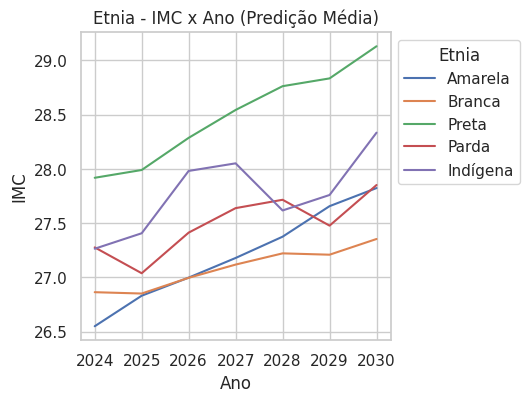

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Etnia - IMC x Ano (Predição Média)")
sns.set_theme(style="whitegrid")

forecastAmarela.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastBranca.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastPreta.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastParda.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)
forecastIndigena.rename(columns={"ds": "Ano","yhat": "IMC"}, inplace=True)

sns.lineplot(data=forecastAmarela, x="Ano", y="IMC", label ="Amarela")
sns.lineplot(data=forecastBranca, x="Ano", y="IMC", label ="Branca")
sns.lineplot(data=forecastPreta, x="Ano", y="IMC", label ="Preta")
sns.lineplot(data=forecastParda, x="Ano", y="IMC", label ="Parda")
a = sns.lineplot(data=forecastIndigena, x="Ano", y="IMC", label ="Indígena")

plt.legend(title='Etnia')
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(forecastIndigena["Ano"])
plt.show()

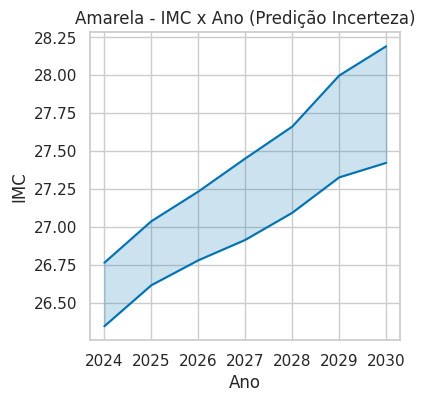

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Amarela - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastAmarela, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastAmarela, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastAmarela["Ano"], forecastAmarela['yhat_lower'], forecastAmarela['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

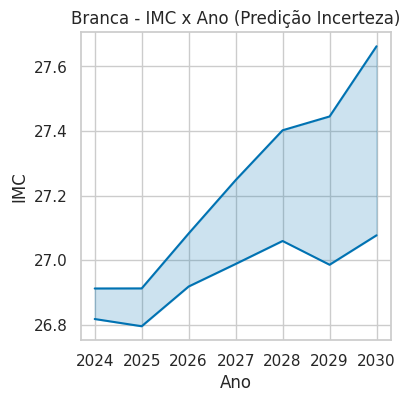

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Branca - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastBranca, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastBranca, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastBranca["Ano"], forecastBranca['yhat_lower'], forecastBranca['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

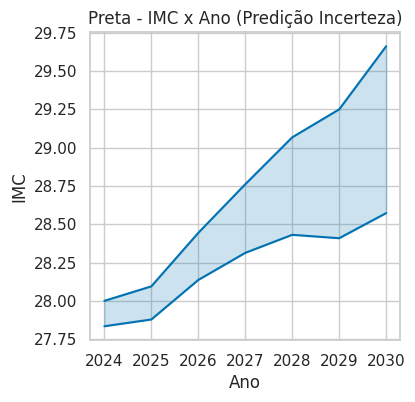

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Preta - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastPreta, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastPreta, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastPreta["Ano"], forecastPreta['yhat_lower'], forecastPreta['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

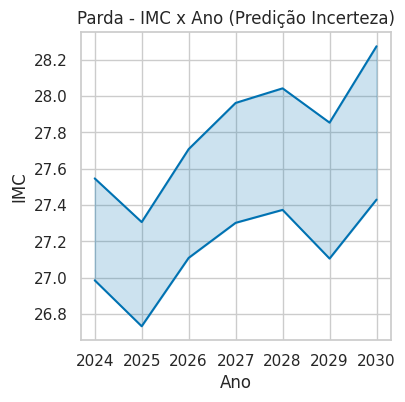

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Parda - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastParda, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastParda, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastParda["Ano"], forecastParda['yhat_lower'], forecastParda['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()

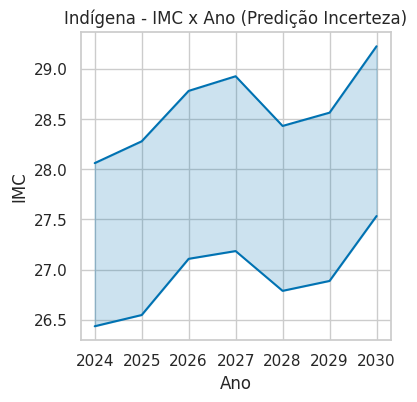

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Indígena - IMC x Ano (Predição Incerteza)")
sns.set_theme(style="whitegrid")

sns.lineplot(data=forecastIndigena, x="Ano", y="yhat_lower", color='#0072B2')
a = sns.lineplot(data=forecastIndigena, x="Ano", y="yhat_upper", color='#0072B2')
a.set(xlabel='Ano', ylabel='IMC')

plt.fill_between(forecastIndigena["Ano"], forecastIndigena['yhat_lower'], forecastIndigena['yhat_upper'], color='#0072B2', alpha=0.2, label='Uncertainty interval')
plt.show()